# Figures 

## ECCO

In [1]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
import gsw
from fastjmd95 import jmd95numba
from fastjmd95 import rho, drhods, drhodt
import json

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [3]:
wmt_budget_terms = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/wmt_budget_terms.zarr'))
wmt_budget_terms.load()

/tmp/ipykernel_2064/560759331.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  wmt_budget_terms = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/wmt_budget_terms.zarr'))


<xarray.Dataset>
Dimensions:               (time: 288, sigma2_bin: 999)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 1992-01-15 ... 2015-12-14
    time_snp              (time) datetime64[ns] NaT 1992-03-01 ... NaT
Data variables: (12/17)
    R1                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R2                    (time, sigma2_bin) float64 6.155e+04 6.155e+04 ... 0.0
    dVdt                  (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_mix             (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_mix_slt         (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_mix_th          (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                    ...
    omega_total_th        (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate      (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate_slt  (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate_th   (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_adv               (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_vel               (time, sigma2_bin) float64 nan nan nan ... nan nan nan

In [4]:
#indices
indices = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/indices.zarr')).load()

In [5]:
indices#.plot()

<xarray.Dataset>
Dimensions:          (time: 288)
Coordinates:
  * time             (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Data variables:
    ecco             (time) float32 -1.17 -0.4881 0.557 ... 0.9576 0.7435 -2.925
    enso             (time) float32 1.884 1.786 1.615 ... 2.599 2.746 2.795
    fw_flx           (time) float32 -1.3 -0.8691 -2.231 ... 0.3026 0.3995 1.555
    heat_flx         (time) float32 0.001594 -0.8675 -1.919 ... -0.1446 5.151
    sam              (time) float64 -0.1225 -0.8858 -0.616 ... 0.8338 0.3187
    windstress_curl  (time) float64 -0.2194 1.103 -0.4354 ... -0.5297 0.2877

## Time mean budgets

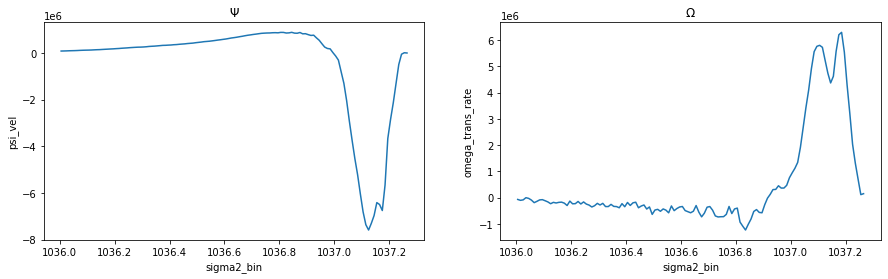

In [6]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1036.0, 1037.27)).plot(ax=ax0)
wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=slice(1036.0, 1037.27)).plot(ax=ax1)
ax0.set_title(r'$\Psi$')
ax1.set_title(r'$\Omega$');

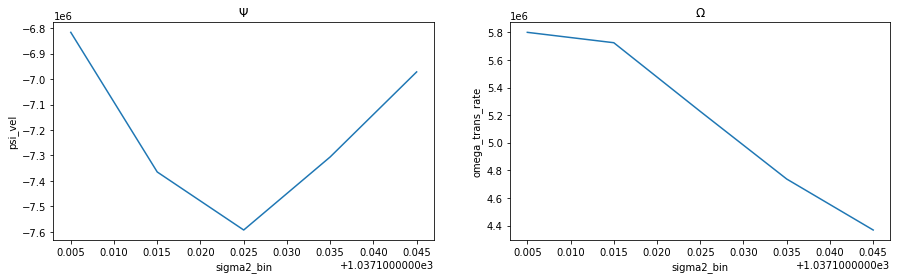

In [7]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1037.10, 1037.15)).plot(ax=ax0)
wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=slice(1037.10, 1037.15)).plot(ax=ax1)
ax0.set_title(r'$\Psi$')
ax1.set_title(r'$\Omega$');

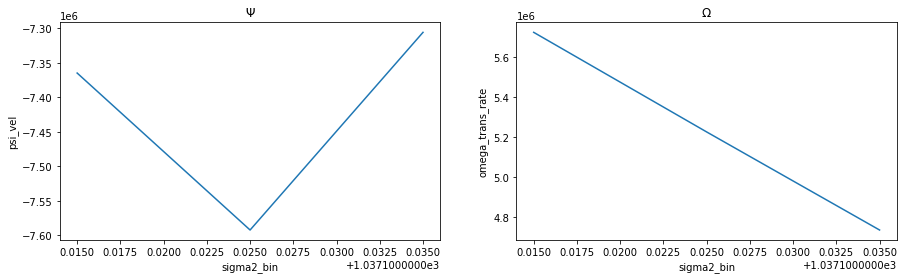

In [8]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1037.11, 1037.14)).plot(ax=ax0)
wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=slice(1037.11, 1037.14)).plot(ax=ax1)
ax0.set_title(r'$\Psi$')
ax1.set_title(r'$\Omega$');

### $\frac{\partial V}{\partial t}$

In [9]:
bottom = (wmt_budget_terms.mean('time').isel(sigma2_bin=-1) - 
          wmt_budget_terms.mean('time').sel(sigma2_bin=1037.125, method='nearest'))/1e6
deep = (wmt_budget_terms.mean('time').sel(sigma2_bin=1037.125, method='nearest') - 
        wmt_budget_terms.mean('time').isel(sigma2_bin=0))/1e6

In [10]:
bottom.dVdt

<xarray.DataArray 'dVdt' ()>
array(1.33620132)

In [11]:
bottom.dVdt + deep.dVdt#+ ((wmt_budget_terms.R1.mean('time')[-1] - wmt_budget_terms.R1.mean('time')[0]).values/1e6)

<xarray.DataArray 'dVdt' ()>
array(-7.74560862e-06)

### E-P-R

### $\Psi$

In [12]:
bottom.psi_vel + deep.psi_vel

<xarray.DataArray 'psi_vel' ()>
array(0.01513492)

### $\Omega$

In [12]:
#deep
omega_deep = (wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=1037.12, method='nearest') - 
              wmt_budget_terms.omega_trans_rate.mean('time')[0])/1e6
omega_deep.load()

<xarray.DataArray 'omega_trans_rate' ()>
array(5.22712671)

In [12]:
terms_on_boundary = wmt_budget_terms.sel(sigma2_bin=1037.125, method='nearest')/1e6
terms_on_boundary

<xarray.Dataset>
Dimensions:               (time: 288)
Coordinates:
    sigma2_bin            float64 1.037e+03
  * time                  (time) datetime64[ns] 1992-01-15 ... 2015-12-14
    time_snp              (time) datetime64[ns] NaT 1992-03-01 ... NaT
Data variables: (12/17)
    R1                    (time) float64 nan 0.7447 1.033 ... -3.141 1.045 nan
    R2                    (time) float64 -0.2767 0.09662 0.7604 ... 1.18 0.8101
    dVdt                  (time) float64 nan -9.871 -4.999 ... -8.347 -2.323 nan
    omega_mix             (time) float64 -1.346 -1.768 -2.521 ... -1.851 -2.245
    omega_mix_slt         (time) float64 -0.8965 -0.4581 ... 0.4091 0.4423
    omega_mix_th          (time) float64 -0.4499 -1.31 -2.073 ... -2.26 -2.687
    ...                    ...
    omega_total_th        (time) float64 nan -9.308 -2.996 ... -1.85 0.03565 nan
    omega_trans_rate      (time) float64 nan -0.9404 0.8156 ... 2.272 0.3351 nan
    omega_trans_rate_slt  (time) float64 nan 0.3702 2.889 ... 3.96 2.602 nan
    omega_trans_rate_th   (time) float64 nan -1.311 -2.074 ... -1.688 -2.266 nan
    psi_adv               (time) float64 nan -9.666 -6.839 ... -7.468 -3.673 nan
    psi_vel               (time) float64 nan -9.763 -7.599 ... -9.305 -4.853 nan

In [13]:
omegas = list()
bdy_omegas = list()

for var in terms_on_boundary.data_vars:
    if var == 'omega_total':
        continue 
    elif var == 'omega_total_slt':
        continue
    elif var == 'omega_total_th':
        continue
    elif var.startswith('omega'):
        omegas.append(var)
        bdy_omegas.append(terms_on_boundary.drop('sigma2_bin').data_vars[var])

In [14]:
omegas

['omega_mix',
 'omega_mix_slt',
 'omega_mix_th',
 'omega_surf',
 'omega_surf_slt',
 'omega_surf_th',
 'omega_trans_rate',
 'omega_trans_rate_slt',
 'omega_trans_rate_th']

In [15]:
bdy_omegas[:1]

[<xarray.DataArray 'omega_mix' (time: 288)>
 array([-1.34638447, -1.76826843, -2.52055532, -2.17451195, -1.34883797,
        -1.40441855, -0.30692953,  0.25287412,  1.06309764,  0.48428811,
         0.67727434,  0.05678597, -0.16788303, -0.13202461,  0.04688955,
         0.022473  ,  0.7085842 ,  0.63425647,  2.04729809,  1.11786585,
         0.94569799,  1.48250748,  0.76262249,  0.89369256,  0.98655011,
         0.55813054,  0.19970743, -1.30134433,  1.33562396,  1.29817334,
         1.46796108,  0.4222553 , -0.1945464 ,  0.25557873,  0.59023924,
         0.92567545, -0.01175897, -0.36483962,  0.01348969, -0.33602888,
        -0.17130963, -0.95040594,  0.20718745, -0.26923023,  0.08195256,
        -0.14675731, -0.84531234, -1.0844723 , -0.94321088, -1.93202842,
        -1.05800788, -0.89293134,  0.05010346, -0.47359163, -0.39144894,
        -0.11062827, -0.5498285 , -0.45598818, -1.06788763, -1.21670607,
        -1.61566374, -1.34442693, -1.03773618, -0.77538772, -1.14938784,
       

In [16]:
len(omegas)

9

In [17]:
len(bdy_omegas)

9

In [18]:
for i in range(9):
    print(bdy_omegas[i].name)

omega_mix
omega_mix_slt
omega_mix_th
omega_surf
omega_surf_slt
omega_surf_th
omega_trans_rate
omega_trans_rate_slt
omega_trans_rate_th


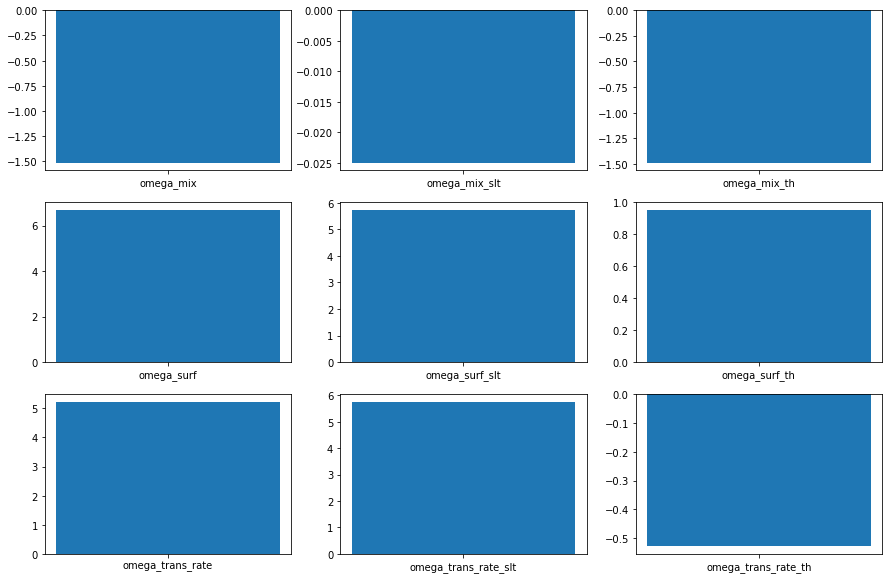

In [19]:
fig, ax = plt.subplots(3,3, figsize=(15,10))
ax = ax.ravel()

for i in range(9):
    ax[i].bar(x=bdy_omegas[i].name, height=bdy_omegas[i].mean('time').values)

In [20]:
- bottom.omega_trans_rate + bottom.omega_mix + bottom.omega_surf

<xarray.DataArray ()>
array(0.04633864)

In [21]:
whole_colmn = wmt_budget_terms.sum('sigma2_bin')/1e6

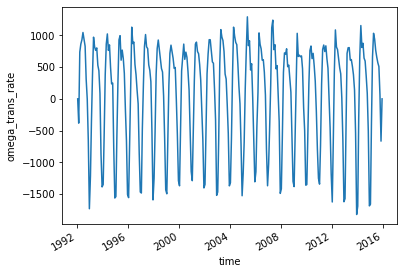

In [22]:
whole_colmn.omega_trans_rate.plot()

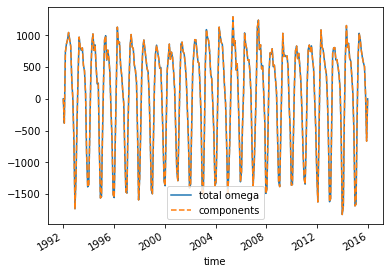

In [23]:
whole_colmn.omega_trans_rate.plot(label='total omega')
(whole_colmn.omega_trans_rate_slt + whole_colmn.omega_trans_rate_th).plot(label='components', linestyle='--')
plt.legend()

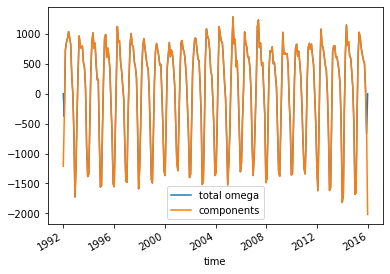

In [24]:
whole_colmn.omega_trans_rate.plot(label='total omega')
(whole_colmn.omega_surf + whole_colmn.omega_mix ).plot(label='components')

plt.legend();

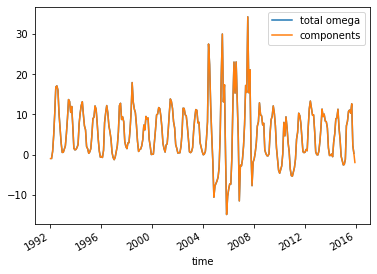

In [25]:
bdy_omegas[6].plot(label='total omega')
(bdy_omegas[3] + bdy_omegas[0] ).plot(label='components')

plt.legend();

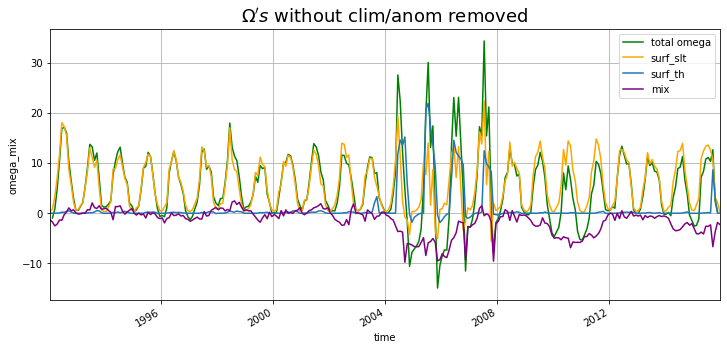

In [26]:
plt.figure(figsize=(12,5))
bdy_omegas[6].plot(label='total omega', color='green')
bdy_omegas[4].plot(label='surf_slt', color='orange')
bdy_omegas[5].plot(label='surf_th', color='C0')
bdy_omegas[0].plot(label='mix', color='purple')

plt.xlim(wmt_budget_terms.time[0], wmt_budget_terms.time[-1])
plt.title(r"$\Omega's$ without clim/anom removed", fontsize=18)

plt.grid()
plt.legend();

### Budget

* $\frac{\partial V}{\partial t} = \Omega_{total} + R1$ $\Omega_{total} \equiv$ hist(weights=tottend); tottend = $\sigma$.diff(time)*vol / $\Delta$ t
* $\Omega_{trans-rate}$
* $\Psi_{adv} = \Psi_{vel} + R2$
* $R3 = \Omega_{total} - \Psi_{adv} - \Omega_{trans-rate}$
* $\frac{\partial V}{\partial t} = \Psi_{vel} + R2 + \Omega_{trans-rate} + R3 + R1$

__SWITCH SIGN OF ALL TERMS SINCE CUM VOL WAS DEFINED $\int_{\sigma_{max}}^{\sigma_{min}}$ (instead of $\int_{\sigma_{min}}^{\sigma_{max}}$) in wmt budget `poster-figs-sigma-ecco-ts-components-SOSEperiod.ipynb`__

* $\frac{\partial V}{\partial t}$ is (+ to -) for bottom wm, (- to +) for deep wm
   * (No longer cumulative volume!) Decreasing rate of volume means less water in wm; conversely, increasing rate of volume means more water in wm.
* $\Psi$ is (+ to -) for bottom wm, (- to +) for deep wm
   * Negative $\Psi$ means OUTflow, positive $\Psi$ means INflow
* $\Omega$ is (- to +) for bottom wm, (+ to -) for deep wm
   * using only one $\Omega$ (on the boundary) yields a positive value, which means positive transformation of deep layer water being added to bottom layer. (+) into layer 2 (bottom) is trying to add volume, (-) from layer 1 (deep) is trying to remove volume.

In [27]:
print('bottom:', bottom.dVdt.values, ' deep:', deep.dVdt.values)

bottom: 1.3362013187408992  deep: -1.3362090643495177


In [28]:
print('bottom:', bottom.psi_vel.values, ' deep:', deep.psi_vel.values)

bottom: 7.5923920804783664  deep: -7.577257157316621


In [29]:
print('bottom:', bottom.omega_trans_rate.values, ' deep:', deep.omega_trans_rate.values)

bottom: -5.204323343338951  deep: 5.227126705131654


In [30]:
bottom = -bottom
deep = -deep

In [31]:
print('correct bottom:', bottom.dVdt.values, ' correct deep:', deep.dVdt.values)

correct bottom: -1.3362013187408992  correct deep: 1.3362090643495177


In [32]:
print('correct bottom:', bottom.psi_vel.values, ' correct deep:', deep.psi_vel.values)

correct bottom: -7.5923920804783664  correct deep: 7.577257157316621


In [33]:
print('correct bottom:', bottom.omega_trans_rate.values, ', correct deep:', deep.omega_trans_rate.values, ', omega on bdy:', 
      bdy_omegas[6].mean('time').values)

correct bottom: 5.204323343338951 , correct deep: -5.227126705131654 , omega on bdy: 5.227126705131654


### __Bottom budget__

In [34]:
bdy_omegas[6].name

'omega_trans_rate'

In [35]:
bottom.dVdt

<xarray.DataArray 'dVdt' ()>
array(-1.33620132)

In [36]:
bottom.psi_vel

<xarray.DataArray 'psi_vel' ()>
array(-7.59239208)

In [37]:
bdy_omegas[6].mean('time')

<xarray.DataArray 'omega_trans_rate' ()>
array(5.22712671)

In [38]:
bdy_omegas[6].mean('time')+bottom.R2

<xarray.DataArray ()>
array(6.08561707)

In [39]:
- bottom.dVdt + bottom.psi_vel + bottom.R2 + bdy_omegas[6].mean('time') + bottom.R1 

<xarray.DataArray ()>
array(0.03101304)

### __Deep budget__

In [42]:
- deep.dVdt + deep.psi_vel + deep.R2 + deep.omega_trans_rate + deep.R1 

<xarray.DataArray ()>
array(-0.00841902)

In [43]:
- deep.dVdt + deep.psi_vel + deep.R2 - bdy_omegas[6].mean('time') + deep.R1 

<xarray.DataArray ()>
array(-0.00841902)

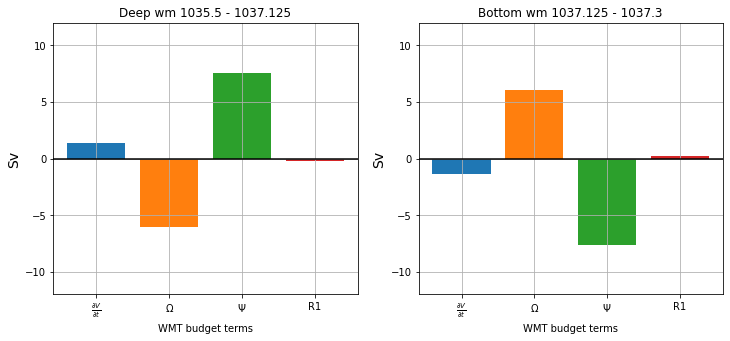

In [38]:
#adding R2 to Omega since R2 reps numerical mixing and Omega is a mixing term
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.bar(x=r'$\frac{\partial V}{\partial t}$', height = deep.dVdt)
ax0.bar(x=r'$\Omega$', height = (deep.omega_trans_rate + deep.R2))
ax0.bar(x=r'$\Psi$', height=deep.psi_vel)
#ax0.bar(x='R2', height=deep.R2)
ax0.bar(x='R1', height=deep.R1)
ax0.axhline(y=0, color='k')
ax0.set_title('Deep wm 1035.5 - 1037.125')
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('WMT budget terms')
ax0.grid()
ax0.set_ylim(-12,12)

ax1.bar(x=r'$\frac{\partial V}{\partial t}$', height = bottom.dVdt)
ax1.bar(x=r'$\Omega$', height = (bottom.omega_trans_rate + bottom.R2))
ax1.bar(x=r'$\Psi$', height=bottom.psi_vel)
#ax1.bar(x='R2', height=bottom.R2)
ax1.bar(x='R1', height=bottom.R1)
ax1.axhline(y=0, color='k')
ax1.set_title('Bottom wm 1037.125 - 1037.3')
ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('WMT budget terms')
ax1.grid()
ax1.set_ylim(-12,12);

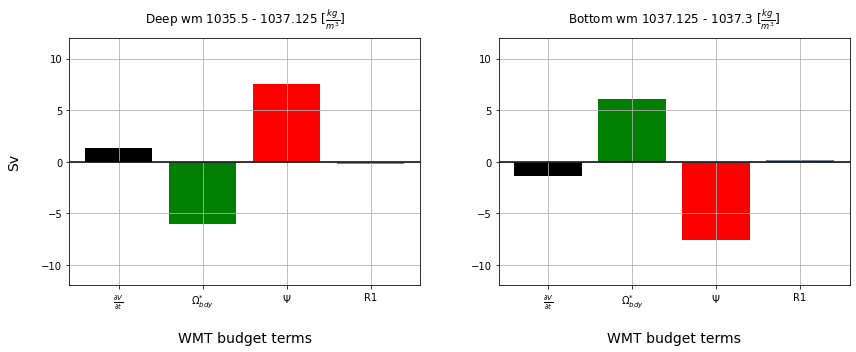

In [39]:
#adding R2 to Omega since R2 reps numerical mixing and Omega is a mixing term
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.bar(x=r'$\frac{\partial V}{\partial t}$', height = deep.dVdt, color='k')
ax0.bar(x=r'$\Omega^{*}_{bdy}$', height = (- bdy_omegas[6].mean('time') + deep.R2), color='green')
ax0.bar(x=r'$\Psi$', height= deep.psi_vel, color='red')
#ax0.bar(x='R2', height=deep.R2)
ax0.bar(x='R1', height=deep.R1, color='lightslategray')
ax0.axhline(y=0, color='k')
ax0.set_title(r'Deep wm 1035.5 - 1037.125 [$\frac{kg}{m^3}$]', pad=15)
ax0.set_ylabel('Sv', fontsize=14, labelpad=20)
ax0.set_xlabel('WMT budget terms', fontsize=14, labelpad=20)
ax0.grid()
ax0.set_ylim(-12,12)

ax1.bar(x=r'$\frac{\partial V}{\partial t}$', height = bottom.dVdt, color='k')
ax1.bar(x=r'$\Omega^{*}_{bdy}$', height = (bdy_omegas[6].mean('time') + bottom.R2), color='green')
ax1.bar(x=r'$\Psi$', height=bottom.psi_vel, color='red')
#ax1.bar(x='R2', height=bottom.R2)
ax1.bar(x='R1', height=bottom.R1, color='lightslategray')
ax1.axhline(y=0, color='k')
ax1.set_title(r'Bottom wm 1037.125 - 1037.3 [$\frac{kg}{m^3}$]', pad=15)
#ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('WMT budget terms', fontsize=14, labelpad=20)
ax1.grid()
ax1.set_ylim(-12,12)
plt.tight_layout(w_pad=5);

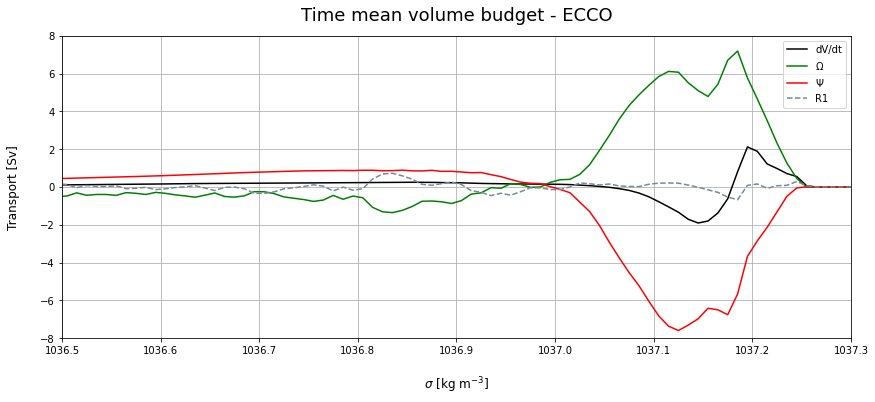

In [40]:
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
((wmt_budget_terms.omega_trans_rate+wmt_budget_terms.R2)/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green')
#(wmt_budget_terms.omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='steelblue', linestyle='dashed')
#(wmt_budget_terms.omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod', linestyle='dashed')
(wmt_budget_terms.psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='red')
#(wmt_budget_terms.R2/1e6).mean(dim='time').plot(label='R2', color='salmon', linestyle='--')
(wmt_budget_terms.R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray', linestyle='--')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
plt.ylim(-8, 8)
plt.xlim(1036.5, 1037.3)
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12, labelpad=20)
plt.ylabel(r'Transport [Sv]', fontsize=12, labelpad=20)
plt.title('Time mean volume budget - ECCO', fontsize=18, pad=15);

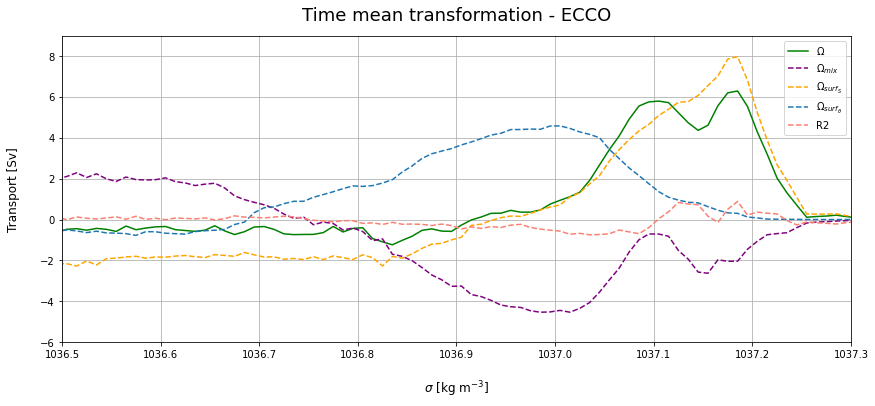

In [41]:
(wmt_budget_terms.omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green', figsize=(12,5))
#(wmt_budget_terms.omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='steelblue', linestyle='dashed')
#(wmt_budget_terms.omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod', linestyle='dashed')
(wmt_budget_terms.omega_mix/1e6).mean(dim='time').plot(label=r'$\Omega_{mix}$', color='purple', linestyle='dashed')
(wmt_budget_terms.omega_surf_slt/1e6).mean(dim='time').plot(label=r'$\Omega_{surf_S}$', color='orange', linestyle='dashed')
(wmt_budget_terms.omega_surf_th/1e6).mean(dim='time').plot(label=r'$\Omega_{surf_\theta}$', color='C0', linestyle='dashed')
(wmt_budget_terms.R2/1e6).mean(dim='time').plot(label='R2', color='salmon', linestyle='--')

plt.legend()
plt.grid()
plt.ylim(-6, 9)
plt.xlim(1036.5, 1037.3)
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12, labelpad=20)
plt.ylabel(r'Transport [Sv]', fontsize=12, labelpad=20)
plt.title('Time mean transformation - ECCO', fontsize=18, pad=15);

### Defining no POlynya years

In [42]:
polynya_yrs = wmt_budget_terms.time.sel(time=slice('2004', '2007')).values
polynya_yrs

array(['2004-01-15T00:00:00.000000000', '2004-02-13T00:00:00.000000000',
       '2004-03-15T00:00:00.000000000', '2004-04-14T00:00:00.000000000',
       '2004-05-15T00:00:00.000000000', '2004-06-14T00:00:00.000000000',
       '2004-07-15T00:00:00.000000000', '2004-08-15T00:00:00.000000000',
       '2004-09-14T00:00:00.000000000', '2004-10-15T00:00:00.000000000',
       '2004-11-14T00:00:00.000000000', '2004-12-15T00:00:00.000000000',
       '2005-01-15T00:00:00.000000000', '2005-02-12T00:00:00.000000000',
       '2005-03-15T00:00:00.000000000', '2005-04-14T00:00:00.000000000',
       '2005-05-15T00:00:00.000000000', '2005-06-14T00:00:00.000000000',
       '2005-07-15T00:00:00.000000000', '2005-08-15T00:00:00.000000000',
       '2005-09-14T00:00:00.000000000', '2005-10-15T00:00:00.000000000',
       '2005-11-14T00:00:00.000000000', '2005-12-15T00:00:00.000000000',
       '2006-01-15T00:00:00.000000000', '2006-02-12T00:00:00.000000000',
       '2006-03-15T00:00:00.000000000', '2006-04-14

In [43]:
str(polynya_yrs[0])

'2004-01-15T00:00:00.000000000'

In [44]:
np.arange(0, len(polynya_yrs))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])

In [45]:
polynya_yrs_list = list()
for i in np.arange(0, len(polynya_yrs)):
    polynya_yrs_list.append(str(polynya_yrs[i]))

In [46]:
wmt_no_polynya = wmt_budget_terms.drop('time_snp').drop_sel(time=polynya_yrs)
wmt_no_polynya

<xarray.Dataset>
Dimensions:               (time: 240, sigma2_bin: 999)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Data variables: (12/17)
    R1                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R2                    (time, sigma2_bin) float64 6.155e+04 6.155e+04 ... 0.0
    dVdt                  (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_mix             (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_mix_slt         (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_mix_th          (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                    ...
    omega_total_th        (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate      (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate_slt  (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate_th   (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_adv               (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_vel               (time, sigma2_bin) float64 nan nan nan ... nan nan nan

## Monthly Climatology

In [99]:
def anomaly(da):
    clim = da.groupby('time.month').mean(dim='time')
    anom = da.groupby('time.month') - clim
    #anom_chunk = anom.chunk({'time':12})
    anom_rolled = anom.rolling(time=12).mean(dim='time') #yearly rolling mean to remove seasonal cycle
    return anom_rolled

In [100]:
#1037.495 to include 1037.5 when slicing
anom_ds = (wmt_no_polynya.sel(sigma2_bin=slice(1036.495, 1037.5)))/1e6

In [101]:
def clim(da):
    clim = da.groupby('time.month').mean(dim='time')
    #anom_rolled = anom.rolling(time=12).mean(dim='time')
    return clim

In [102]:
clim_ds = anom_ds

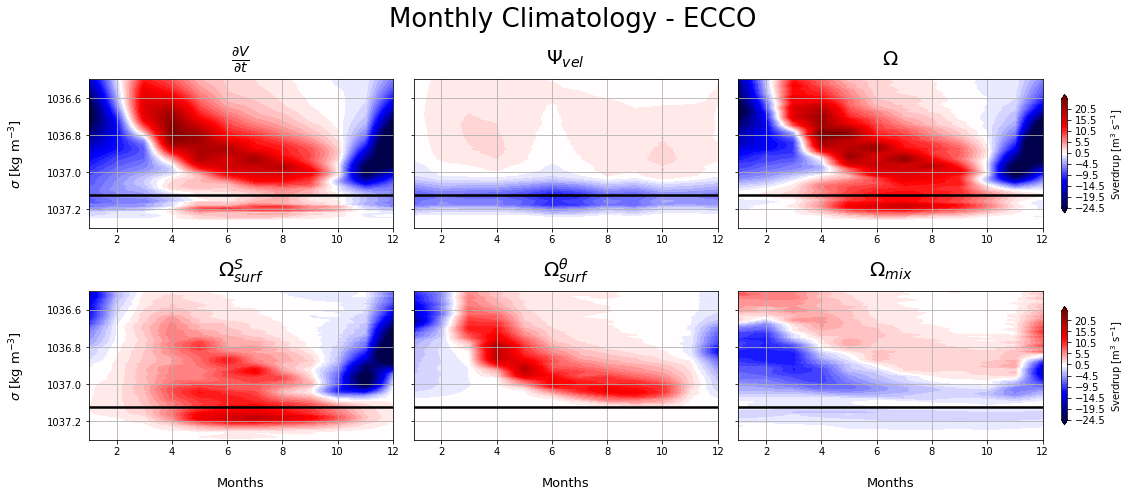

In [127]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

levels = np.arange(-25, 25) + 0.5

dVdt_clim = clim(clim_ds.dVdt)
c = ax[0,0].contourf(dVdt_clim.month, 
                   dVdt_clim.sigma2_bin,
                   dVdt_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,0])
ax[0,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=13, labelpad=20)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20, pad=15)
ax[0,0].grid()
ax[0,0].set_ylim(1037.3, 1036.5)
ax[0,0].axhline(y=1037.125, color='k', linewidth=2.5)

psi_vel_clim = clim(clim_ds.psi_vel)
c_psi = ax[0,1].contourf(psi_vel_clim.month, psi_vel_clim.sigma2_bin, psi_vel_clim.T,
                         cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[0,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title(r'$\Psi_{vel}$', fontsize=20, pad=15)
ax[0,1].grid()
ax[0,1].axhline(y=1037.125, color='k', linewidth=2.5)

omega_clim = (clim(clim_ds.omega_trans_rate) + clim(clim_ds.R2))
c_omega = ax[0,2].contourf(omega_clim.month, omega_clim.sigma2_bin, omega_clim.T,
                           cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[0,2])
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,2].set_title(r'$\Omega$', fontsize=20, pad=15)
ax[0,2].grid()
ax[0,2].axhline(y=1037.125, color='k', linewidth=2.5)

omega_surf_slt_clim = clim(clim_ds.omega_surf_slt)
c_surf_slt = ax[1,0].contourf(omega_surf_slt_clim.month, 
                                omega_surf_slt_clim.sigma2_bin, 
                                omega_surf_slt_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_surf_slt, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[1,0])
ax[1,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=13, labelpad=20)
ax[1,0].set_xlabel('Months', fontsize=13, labelpad=20)
ax[1,0].set_title('$\Omega^{S}_{surf}$', fontsize=20, pad=15)
ax[1,0].grid()
ax[1,0].axhline(y=1037.125, color='k', linewidth=2.5)

omega_surf_th_clim = clim(clim_ds.omega_surf_th)
c_surf_th = ax[1,1].contourf(omega_surf_th_clim.month, omega_surf_th_clim.sigma2_bin, 
                        omega_surf_th_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_surf_th, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[1,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,1].set_xlabel('Months', fontsize=13, labelpad=20)
ax[1,1].set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20, pad=15)
ax[1,1].grid()
ax[1,1].axhline(y=1037.125, color='k', linewidth=2.5)

omega_mix__clim = clim(clim_ds.omega_mix)
c_mix = ax[1,2].contourf(omega_mix__clim.month, omega_mix__clim.sigma2_bin, omega_mix__clim.T, 
                        cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_mix, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[1,2])
#ax[1,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,2].set_xlabel('Months', fontsize=13, labelpad=20)
ax[1,2].set_title(r'$\Omega_{mix}$', fontsize=20, pad=15)
ax[1,2].grid()
ax[1,2].axhline(y=1037.125, color='k', linewidth=2.5)

plt.suptitle('Monthly Climatology - ECCO', fontsize=26)
plt.tight_layout()
plt.savefig('clim-pcolor-ecco.pdf');

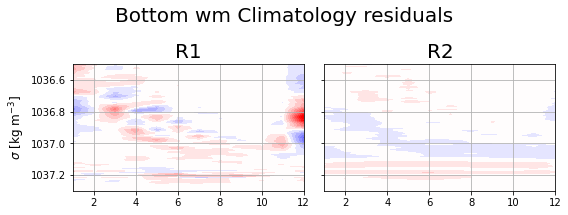

In [104]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

levels = np.arange(-20, 20) + 0.5

R1_clim = clim(clim_ds.R1)
c = ax0.contourf(R1_clim.month, 
                   R1_clim.sigma2_bin,
                   R1_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,0])
ax0.set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax0.set_title('R1', fontsize=20)
ax0.grid()
ax0.set_ylim(1037.3, 1036.5)

R2_clim = clim(clim_ds.R2)
c_psi = ax1.contourf(R2_clim.month, R2_clim.sigma2_bin, R2_clim.T,
                         cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[0,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax1.set_title('R2', fontsize=20)
ax1.grid()


plt.suptitle('Bottom wm Climatology residuals', fontsize=20)
plt.tight_layout();

### $\frac{\partial V}{\partial t}$

In [106]:
#remember we are switching signs!
dVdt_clim_bot = - dVdt_clim.isel(sigma2_bin=-1) + dVdt_clim.sel(sigma2_bin=1037.125, method='nearest')
dVdt_clim_bot.load()

<xarray.DataArray 'dVdt' (month: 12)>
array([-6.93119515, -5.72156064, -5.40910304, -1.86805891,  0.90938331,
        0.69494378,  2.53701625,  4.20868999,  2.26597867,  0.49217741,
       -3.42681295, -5.39983099])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

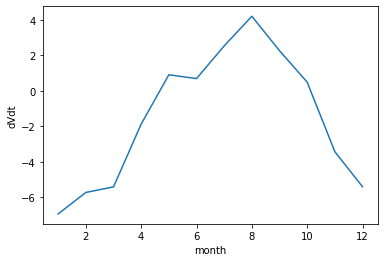

In [107]:
dVdt_clim_bot.plot();

### $\Psi$

In [108]:
#remember we are switching signs!
psi_clim_bot = - psi_vel_clim.isel(sigma2_bin=-1) + psi_vel_clim.sel(sigma2_bin=1037.125, method='nearest')
psi_clim_bot.load()

<xarray.DataArray 'psi_vel' (month: 12)>
array([ -7.85826674,  -6.50049935,  -6.98053516,  -7.30580567,
        -8.72745975, -10.91198319,  -9.85228967,  -6.97065902,
        -7.61989455,  -5.36949161,  -5.59841072,  -6.24215233])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

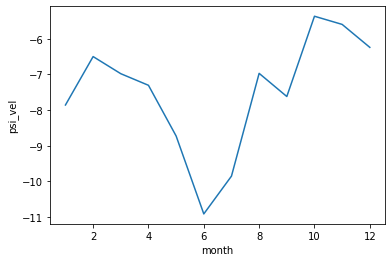

In [109]:
psi_clim_bot.plot();

### $\Omega$

In [76]:
omegas

['omega_mix',
 'omega_mix_slt',
 'omega_mix_th',
 'omega_surf',
 'omega_surf_slt',
 'omega_surf_th',
 'omega_trans_rate',
 'omega_trans_rate_slt',
 'omega_trans_rate_th']

In [110]:
omega_clim_bot = clim(bdy_omegas[6])
omega_clim_bot.load()

<xarray.DataArray 'omega_trans_rate' (month: 12)>
array([-1.17445213, -0.55905598,  0.4945081 ,  4.39386419,  9.02436265,
       12.85588335, 13.9507894 , 11.02286189,  9.48243781,  4.43851845,
       -0.71264028, -1.01852494])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [111]:
omega_surf_slt_clim_bot = clim(bdy_omegas[4]).load()
omega_surf_th_clim_bot = clim(bdy_omegas[5]).load()
omega_mix_clim_bot = clim(bdy_omegas[0]).load()

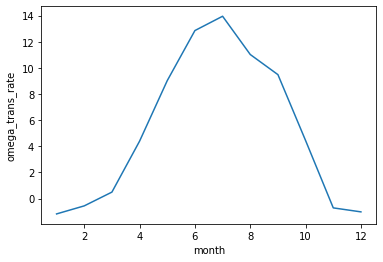

In [112]:
omega_clim_bot.plot();

### Residuals

In [113]:
#remember we are switching signs!
R1_clim_bot = - R1_clim.isel(sigma2_bin=-1) + R1_clim.sel(sigma2_bin=1037.125, method='nearest')
R1_clim_bot.load()

<xarray.DataArray 'R1' (month: 12)>
array([ 0.84186762,  0.19488149, -0.30675123, -0.23242113,  0.09945471,
       -0.26737671, -0.10521748,  0.12469282,  0.52984709, -0.07702079,
        0.1771911 ,  0.46870487])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [114]:
#remember we are switching signs!
R2_clim_bot = - R2_clim.isel(sigma2_bin=-1) + R2_clim.sel(sigma2_bin=1037.125, method='nearest')
R2_clim_bot.load()

<xarray.DataArray 'R2' (month: 12)>
array([0.51230557, 0.52521915, 0.85871329, 0.78182849, 0.91808722,
       0.86729332, 0.98284242, 1.02175144, 0.84730849, 0.80306874,
       0.62610153, 0.45000564])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

### __Bottom climatology budget__

In [125]:
clim_budget = - dVdt_clim_bot + psi_clim_bot + omega_clim_bot + R1_clim_bot + R2_clim_bot
clim_budget

<xarray.DataArray (month: 12)>
array([  0.36510516,  -0.66092188,  -2.91580102, -10.57456014,
       -18.1731085 , -22.89762928, -24.02256798, -21.10330444,
       -17.87706975, -11.08981783,  -3.37946773,  -0.33350814])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [123]:
clim_bdgt_nores = - dVdt_clim_bot + psi_clim_bot + omega_clim_bot 
clim_bdgt_nores

<xarray.DataArray (month: 12)>
array([ -0.98906802,  -1.38102253,  -3.46776308, -11.12396749,
       -19.19065043, -23.49754588, -24.90019293, -22.24974871,
       -19.25422533, -11.81586578,  -4.18276037,  -1.25221865])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

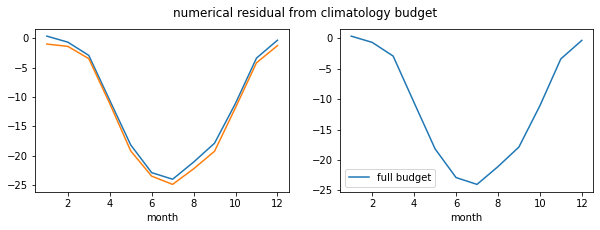

In [126]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
clim_budget.plot(ax=ax0, label='full budget')
clim_bdgt_nores.plot(ax=ax0, label='no residuals')

clim_budget.plot(ax=ax1, label='full budget')

plt.legend()
plt.suptitle('numerical residual from climatology budget');

In [70]:
#remember we are switching signs!
R1_clim_bot = - R1_clim.isel(sigma2_bin=-1) + R1_clim.isel(sigma2_bin=0)
R1_clim_bot.load()

<xarray.DataArray 'R1' (month: 12)>
array([ 0.84186762,  0.19488149, -0.30675123, -0.23242113,  0.09945471,
       -0.26737671, -0.10521748,  0.12469282,  0.52984709, -0.07702079,
        0.1771911 ,  0.46870487])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [71]:
#remember we are switching signs!
R2_clim_bot = - R2_clim.isel(sigma2_bin=-1) + R2_clim.isel(sigma2_bin=0)
R2_clim_bot.load()

<xarray.DataArray 'R2' (month: 12)>
array([0.51230557, 0.52521915, 0.85871329, 0.78182849, 0.91808722,
       0.86729332, 0.98284242, 1.02175144, 0.84730849, 0.80306874,
       0.62610153, 0.45000564])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [72]:
clim_budget = - dVdt_clim_bot + psi_clim_bot + omega_clim_bot + R1_clim_bot + R2_clim_bot
clim_budget

<xarray.DataArray (month: 12)>
array([-0.74735052, -0.61789404, -0.52496195, -0.49447522,  0.40506152,
        1.84887298,  2.43910843,  0.98995715,  0.97372018, -0.69710261,
       -2.08094542, -0.94213577])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [73]:
clim_bdgt_nores = - dVdt_clim_bot + psi_clim_bot + omega_clim_bot 
clim_bdgt_nores

<xarray.DataArray (month: 12)>
array([-2.10152371, -1.33799469, -1.07692401, -1.04388257, -0.61248041,
        1.24895637,  1.56148348, -0.15648711, -0.4034354 , -1.42315057,
       -2.88423805, -1.86084628])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

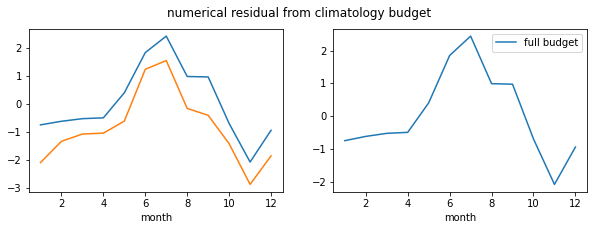

In [74]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
clim_budget.plot(ax=ax0, label='full budget')
clim_bdgt_nores.plot(ax=ax0, label='no residuals')

clim_budget.plot(ax=ax1, label='full budget')

plt.legend()
plt.suptitle('numerical residual from climatology budget');

## BOTTOM Monthly Climatology

In [64]:
def anomaly(da):
    clim = da.groupby('time.month').mean(dim='time')
    anom = da.groupby('time.month') - clim
    #anom_chunk = anom.chunk({'time':12})
    anom_rolled = anom.rolling(time=12).mean(dim='time') #yearly rolling mean to remove seasonal cycle
    return anom_rolled

In [65]:
#1037.115 to include 1037.125 when slicing
anom_ds = (wmt_budget_terms.sel(sigma2_bin=slice(1037.115, 1037.5)))/1e6

In [66]:
def clim(da):
    clim = da.groupby('time.month').mean(dim='time')
    #anom_rolled = anom.rolling(time=12).mean(dim='time')
    return clim

In [67]:
clim_ds = wmt_no_polynya.sel(sigma2_bin=slice(1037.115, 1037.5)) / 1e6

In [68]:
clim_ds

<xarray.Dataset>
Dimensions:               (sigma2_bin: 37, time: 240)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Data variables: (12/17)
    R1                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R2                    (time, sigma2_bin) float64 -0.2767 -0.2357 ... 0.0 0.0
    dVdt                  (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_mix             (time, sigma2_bin) float64 -1.346 -1.418 ... 0.0 0.0
    omega_mix_slt         (time, sigma2_bin) float64 -0.8965 0.2041 ... 0.0 0.0
    omega_mix_th          (time, sigma2_bin) float64 -0.4499 -1.622 ... 0.0 0.0
    ...                    ...
    omega_total_th        (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate      (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate_slt  (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate_th   (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_adv               (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_vel               (time, sigma2_bin) float64 nan nan nan ... nan nan nan

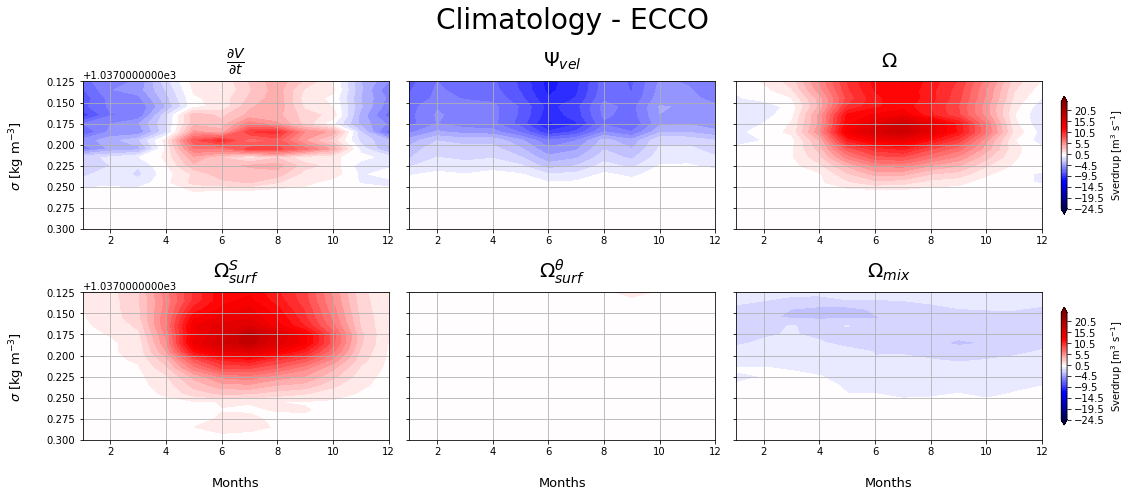

In [69]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

levels = np.arange(-25, 25) + 0.5

dVdt_clim = clim(clim_ds.dVdt)
c = ax[0,0].contourf(dVdt_clim.month, 
                   dVdt_clim.sigma2_bin,
                   dVdt_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,0])
ax[0,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=13, labelpad=20)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20, pad=15)
ax[0,0].grid()
ax[0,0].set_ylim(1037.3, 1037.125)

psi_vel_clim = clim(clim_ds.psi_vel)
c_psi = ax[0,1].contourf(psi_vel_clim.month, psi_vel_clim.sigma2_bin, psi_vel_clim.T,
                         cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[0,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title(r'$\Psi_{vel}$', fontsize=20, pad=15)
ax[0,1].grid()

omega_clim = (clim(clim_ds.omega_trans_rate) + clim(clim_ds.R2))
c_omega = ax[0,2].contourf(omega_clim.month, omega_clim.sigma2_bin, omega_clim.T,
                           cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[0,2])
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,2].set_title(r'$\Omega$', fontsize=20, pad=15)
ax[0,2].grid()

omega_surf_slt_clim = clim(clim_ds.omega_surf_slt)
c_surf_slt = ax[1,0].contourf(omega_surf_slt_clim.month, 
                                omega_surf_slt_clim.sigma2_bin, 
                                omega_surf_slt_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_surf_slt, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[1,0])
ax[1,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=13, labelpad=20)
ax[1,0].set_xlabel('Months', fontsize=13, labelpad=20)
ax[1,0].set_title('$\Omega^{S}_{surf}$', fontsize=20, pad=15)
ax[1,0].grid()

omega_surf_th_clim = clim(clim_ds.omega_surf_th)
c_surf_th = ax[1,1].contourf(omega_surf_th_clim.month, omega_surf_th_clim.sigma2_bin, 
                        omega_surf_th_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_surf_th, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[1,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,1].set_xlabel('Months', fontsize=13, labelpad=20)
ax[1,1].set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20, pad=15)
ax[1,1].grid()

omega_mix__clim = clim(clim_ds.omega_mix)
c_mix = ax[1,2].contourf(omega_mix__clim.month, omega_mix__clim.sigma2_bin, omega_mix__clim.T, 
                        cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_mix, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[1,2])
#ax[1,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,2].set_xlabel('Months', fontsize=13, labelpad=20)
ax[1,2].set_title(r'$\Omega_{mix}$', fontsize=20, pad=15)
ax[1,2].grid()

plt.suptitle('Climatology - ECCO', fontsize=28)
plt.tight_layout();

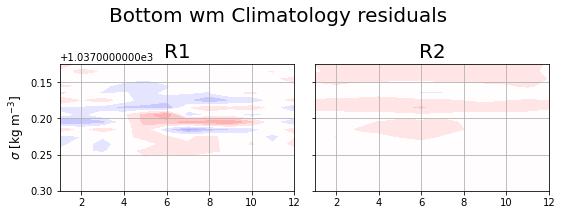

In [70]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

levels = np.arange(-20, 20) + 0.5

R1_clim = clim(clim_ds.R1)
c = ax0.contourf(R1_clim.month, 
                   R1_clim.sigma2_bin,
                   R1_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,0])
ax0.set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax0.set_title('R1', fontsize=20)
ax0.grid()
ax0.set_ylim(1037.3, 1037.125)

R2_clim = clim(clim_ds.R2)
c_psi = ax1.contourf(R2_clim.month, R2_clim.sigma2_bin, R2_clim.T,
                         cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[0,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax1.set_title('R2', fontsize=20)
ax1.grid()


plt.suptitle('Bottom wm Climatology residuals', fontsize=20)
plt.tight_layout();

In [71]:
clim_ecco = xr.merge([dVdt_clim.rename('dVdt_clim'), psi_vel_clim.rename('psi_vel_clim'), 
                      omega_clim.rename('omega_clim'), omega_mix__clim.rename('omega_mix__clim'), 
                      omega_surf_slt_clim.rename('omega_surf_slt_clim'), omega_surf_th_clim.rename('omega_surf_th_clim'),
                      R1_clim.rename('R1_clim'), R2_clim.rename('R2_clim')])
clim_ecco

<xarray.Dataset>
Dimensions:              (sigma2_bin: 37, month: 12)
Coordinates:
  * sigma2_bin           (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
  * month                (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    dVdt_clim            (month, sigma2_bin) float64 -6.927 -7.652 ... -0.002153
    psi_vel_clim         (month, sigma2_bin) float64 -7.858 -7.607 ... 0.0 0.0
    omega_clim           (month, sigma2_bin) float64 0.06064 ... -0.001771
    omega_mix__clim      (month, sigma2_bin) float64 -0.9449 ... -0.001948
    omega_surf_slt_clim  (month, sigma2_bin) float64 0.4866 0.4597 ... 0.0 0.0
    omega_surf_th_clim   (month, sigma2_bin) float64 -0.02011 -0.004577 ... 0.0
    R1_clim              (month, sigma2_bin) float64 0.848 0.3009 ... -0.0001053
    R2_clim              (month, sigma2_bin) float64 0.5126 0.4314 ... 0.0002797

### $\frac{\partial V}{\partial t}$

In [72]:
#remember we are switching signs!
dVdt_clim_bot = - dVdt_clim.isel(sigma2_bin=-1) + dVdt_clim.sel(sigma2_bin=0, method='nearest')
dVdt_clim_bot.load()

<xarray.DataArray 'dVdt' (month: 12)>
array([-6.93119515, -5.72156064, -5.40910304, -1.86805891,  0.90938331,
        0.69494378,  2.53701625,  4.20868999,  2.26597867,  0.49217741,
       -3.42681295, -5.39983099])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

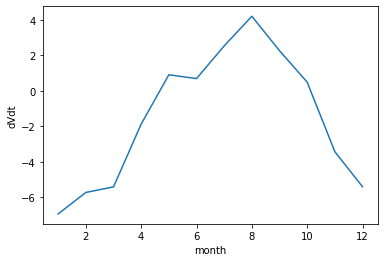

In [73]:
dVdt_clim_bot.plot();

### $\Psi$

In [74]:
#remember we are switching signs!
psi_clim_bot = - psi_vel_clim.isel(sigma2_bin=-1) + psi_vel_clim.isel(sigma2_bin=0)
psi_clim_bot.load()

<xarray.DataArray 'psi_vel' (month: 12)>
array([ -7.85826674,  -6.50049935,  -6.98053516,  -7.30580567,
        -8.72745975, -10.91198319,  -9.85228967,  -6.97065902,
        -7.61989455,  -5.36949161,  -5.59841072,  -6.24215233])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

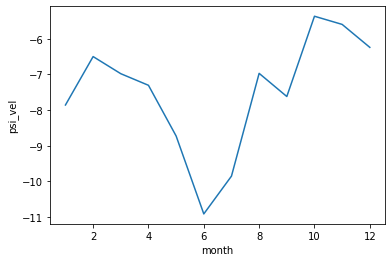

In [75]:
psi_clim_bot.plot();

### $\Omega$

In [76]:
omegas

['omega_mix',
 'omega_mix_slt',
 'omega_mix_th',
 'omega_surf',
 'omega_surf_slt',
 'omega_surf_th',
 'omega_trans_rate',
 'omega_trans_rate_slt',
 'omega_trans_rate_th']

In [77]:
omega_clim_bot = clim(bdy_omegas[6])
omega_clim_bot.load()

<xarray.DataArray 'omega_trans_rate' (month: 12)>
array([-1.17445213, -0.55905598,  0.4945081 ,  4.39386419,  9.02436265,
       12.85588335, 13.9507894 , 11.02286189,  9.48243781,  4.43851845,
       -0.71264028, -1.01852494])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [78]:
omega_surf_slt_clim_bot = clim(bdy_omegas[4]).load()
omega_surf_th_clim_bot = clim(bdy_omegas[5]).load()
omega_mix_clim_bot = clim(bdy_omegas[0]).load()

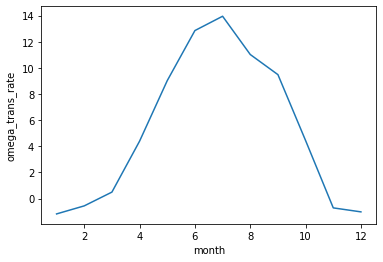

In [79]:
omega_clim_bot.plot();

### Residuals

In [80]:
#remember we are switching signs!
R1_clim_bot = - R1_clim.isel(sigma2_bin=-1) + R1_clim.isel(sigma2_bin=0)
R1_clim_bot.load()

<xarray.DataArray 'R1' (month: 12)>
array([ 0.84186762,  0.19488149, -0.30675123, -0.23242113,  0.09945471,
       -0.26737671, -0.10521748,  0.12469282,  0.52984709, -0.07702079,
        0.1771911 ,  0.46870487])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [81]:
#remember we are switching signs!
R2_clim_bot = - R2_clim.isel(sigma2_bin=-1) + R2_clim.isel(sigma2_bin=0)
R2_clim_bot.load()

<xarray.DataArray 'R2' (month: 12)>
array([0.51230557, 0.52521915, 0.85871329, 0.78182849, 0.91808722,
       0.86729332, 0.98284242, 1.02175144, 0.84730849, 0.80306874,
       0.62610153, 0.45000564])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

### __Bottom climatology budget__

In [82]:
clim_budget = - dVdt_clim_bot + psi_clim_bot + omega_clim_bot + R1_clim_bot + R2_clim_bot
clim_budget

<xarray.DataArray (month: 12)>
array([-0.74735052, -0.61789404, -0.52496195, -0.49447522,  0.40506152,
        1.84887298,  2.43910843,  0.98995715,  0.97372018, -0.69710261,
       -2.08094542, -0.94213577])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [83]:
clim_bdgt_nores = - dVdt_clim_bot + psi_clim_bot + omega_clim_bot 
clim_bdgt_nores

<xarray.DataArray (month: 12)>
array([-2.10152371, -1.33799469, -1.07692401, -1.04388257, -0.61248041,
        1.24895637,  1.56148348, -0.15648711, -0.4034354 , -1.42315057,
       -2.88423805, -1.86084628])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

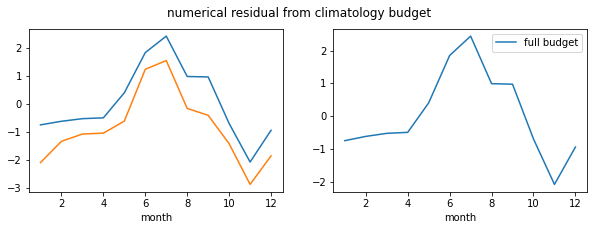

In [84]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
clim_budget.plot(ax=ax0, label='full budget')
clim_bdgt_nores.plot(ax=ax0, label='no residuals')

clim_budget.plot(ax=ax1, label='full budget')

plt.legend()
plt.suptitle('numerical residual from climatology budget');

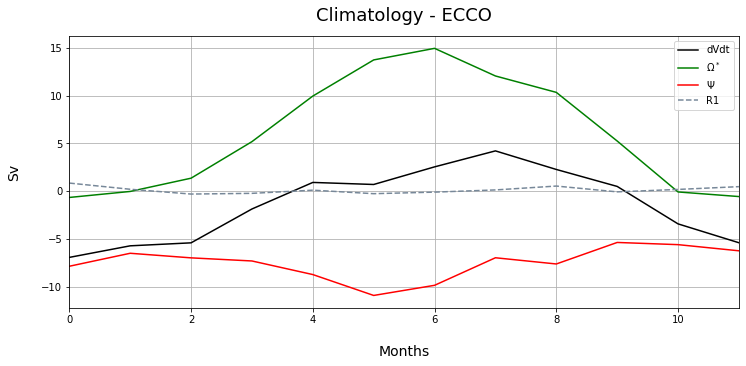

In [75]:
plt.figure(figsize=(12,5))
plt.plot(dVdt_clim_bot, label='dVdt', color='k')
plt.plot((omega_clim_bot+R2_clim_bot), label=r'$\Omega^*$', color='green')
plt.plot(psi_clim_bot, label=r'$\Psi$', color='red')
plt.plot(R1_clim_bot, label='R1', color='lightslategray', linestyle='--')
#plt.plot(R2_clim_bot, label='R2', color='salmon', linestyle='--')
plt.title('Climatology - ECCO', fontsize=18, pad=15)
plt.ylabel('Sv', fontsize=14, labelpad=20)
plt.xlabel('Months', fontsize=14, labelpad=20)
plt.xlim(0,11)

plt.legend()
plt.grid();

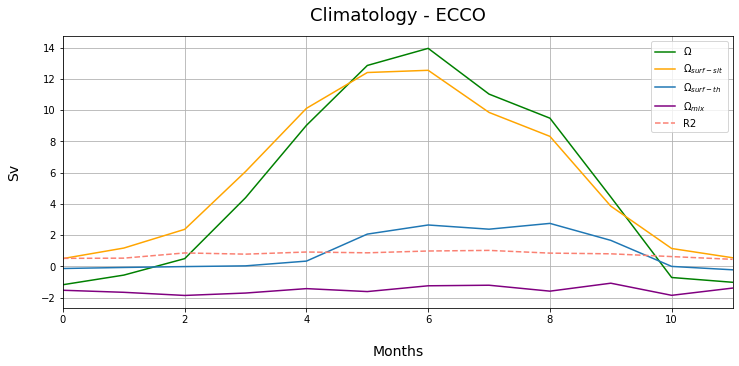

In [76]:
plt.figure(figsize=(12,5))
plt.plot(omega_clim_bot, label=r'$\Omega$', color='green')
plt.plot(omega_surf_slt_clim_bot, label=r'$\Omega_{surf-slt}$', color='orange')
plt.plot(omega_surf_th_clim_bot, label=r'$\Omega_{surf-th}$', color='C0')
plt.plot(omega_mix_clim_bot, label=r'$\Omega_{mix}$', color='purple')
plt.plot(R2_clim_bot, label='R2', color='salmon', linestyle='--')
plt.title('Climatology - ECCO', fontsize=18, pad=15)
plt.ylabel('Sv', fontsize=14, labelpad=20)
plt.xlabel('Months', fontsize=14, labelpad=20)
plt.xlim(0,11)
plt.grid()
plt.legend();

In [77]:
omega_clim_bot.mean('month')

<xarray.DataArray 'omega_trans_rate' ()>
array(5.18321271)

In [78]:
(omega_surf_slt_clim_bot + omega_surf_th_clim_bot + omega_mix_clim_bot).mean('month')

<xarray.DataArray ()>
array(5.18062971)

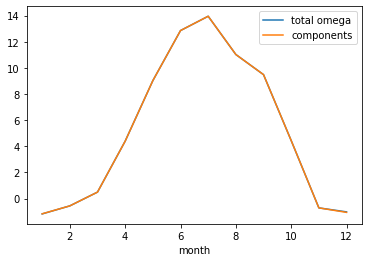

In [79]:
omega_clim_bot.plot(label='total omega')
(omega_surf_slt_clim_bot + omega_surf_th_clim_bot + omega_mix_clim_bot).plot(label='components')

plt.legend();

## Anomaly

In [128]:
import warnings
warnings.filterwarnings("ignore")

In [129]:
year_start_index = list(np.arange(0, 23, 5) * 12) #[0, 12, 24, 36, 48, ]

In [143]:
bot_wm = wmt_budget_terms.sel(sigma2_bin=slice(1036.495, 1037.5)) / 1e6
anom_unrolled = bot_wm.groupby('time.month') - clim(clim_ds)
anom_before_drop = anom_unrolled.rolling(time=12).mean(dim='time')
anom = anom_before_drop.drop(['time_snp', 'month'])

In [144]:
anom

<xarray.Dataset>
Dimensions:               (sigma2_bin: 99, time: 288)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Data variables: (12/17)
    R1                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R2                    (time, sigma2_bin) float64 nan nan ... 0.01865
    dVdt                  (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_mix             (time, sigma2_bin) float64 nan nan ... 0.002479
    omega_mix_slt         (time, sigma2_bin) float64 nan nan ... 0.001735
    omega_mix_th          (time, sigma2_bin) float64 nan nan ... 0.0007436
    ...                    ...
    omega_total_th        (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate      (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate_slt  (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate_th   (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_adv               (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_vel               (time, sigma2_bin) float64 nan nan nan ... nan nan nan

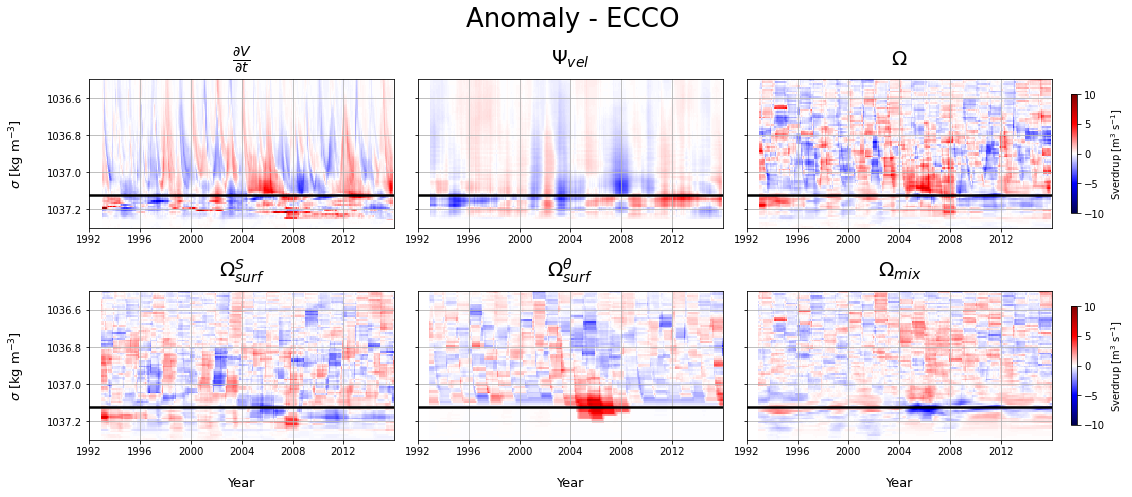

In [164]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

c = ax[0,0].pcolormesh(anom.dVdt.time.values, 
                   anom.dVdt.sigma2_bin, 
                   anom.dVdt.T, vmin=-10, vmax=10, cmap='seismic')
ax[0,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=13, labelpad=20)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20, pad=15)
#ax[0,0].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,0].set_xticklabels(np.arange(2006, 2011))
ax[0,0].grid()
ax[0,0].set_ylim(1037.3, 1036.5)
ax[0,0].axhline(y=1037.125, color='k', linewidth=2.5)

c_psi = ax[0,1].pcolormesh(anom.psi_vel.time.values, anom.psi_vel.sigma2_bin, anom.psi_vel.T,
                        vmin=-10, vmax=10, cmap='seismic')
ax[0,1].set_title(r'$\Psi_{vel}$', fontsize=20, pad=15)
#ax[0,1].set_ylim(1037.3, 1036.5)
#ax[0,1].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,1].set_xticklabels(np.arange(2006, 2011))
ax[0,1].grid()
ax[0,1].axhline(y=1037.125, color='k', linewidth=2.5)

c_omega = ax[0,2].pcolormesh(anom.omega_trans_rate.time.values, anom.omega_trans_rate.sigma2_bin, anom.omega_trans_rate.T,
                        vmin=-10, vmax=10, cmap='seismic')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[0,2])
ax[0,2].set_title(r'$\Omega$', fontsize=20, pad=15)
#ax[0,2].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,2].set_xticklabels(np.arange(2006, 2011))
ax[0,2].grid()
ax[0,2].axhline(y=1037.125, color='k', linewidth=2.5)

c_surf_slt = ax[1,0].pcolormesh(anom.omega_surf_slt.time.values, 
                                anom.omega_surf_slt.sigma2_bin, 
                                anom.omega_surf_slt.T, vmin=-10, vmax=10, cmap='seismic')
ax[1,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=13, labelpad=20)
ax[1,0].set_xlabel('Year', fontsize=13, labelpad=20)
ax[1,0].set_title('$\Omega^{S}_{surf}$', fontsize=20, pad=15)
#ax[1,0].set_xticks(anom.dVdt.time[year_start_index])
#ax[1,0].set_xticklabels(np.arange(2006, 2011))
ax[1,0].grid()
ax[1,0].axhline(y=1037.125, color='k', linewidth=2.5)

c_surf_th = ax[1,1].pcolormesh(anom.omega_surf_th.time.values, anom.omega_surf_th.sigma2_bin, 
                        anom.omega_surf_th.T, vmin=-10, vmax=10, cmap='seismic')
ax[1,1].set_xlabel('Year', fontsize=13, labelpad=20)
ax[1,1].set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20, pad=15)
#ax[1,1].set_ylim(1037.3, 1036.5)
#ax[1,1].set_xticks(anom.dVdt.time[year_start_index])
#ax[1,1].set_xticklabels(np.arange(2006, 2011))
ax[1,1].grid()
ax[1,1].axhline(y=1037.125, color='k', linewidth=2.5)

c_mix = ax[1,2].pcolormesh(anom.omega_mix.time.values, anom.omega_mix.sigma2_bin, anom.omega_mix.T, 
                        vmin=-10, vmax=10, cmap='seismic')
plt.colorbar(c_mix, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[1,2])
ax[1,2].set_xlabel('Year', fontsize=13, labelpad=20)
ax[1,2].set_title(r'$\Omega_{mix}$', fontsize=20, pad=15)
#ax[1,2].set_xticks(anom.dVdt.time[year_start_index])
#ax[1,2].set_xticklabels(np.arange(2006, 2011))
ax[1,2].grid()
ax[1,2].axhline(y=1037.125, color='k', linewidth=2.5)

plt.suptitle('Anomaly - ECCO', fontsize=26)
plt.tight_layout()
plt.savefig('anom-pcolor-ecco.pdf');

In [151]:
anom_bot = - anom.isel(sigma2_bin=-1) + anom.sel(sigma2_bin=1037.125, method='nearest')
anom_bot

<xarray.Dataset>
Dimensions:               (time: 288)
Coordinates:
  * time                  (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Data variables: (12/17)
    R1                    (time) float64 nan nan nan nan ... 0.5945 0.6387 nan
    R2                    (time) float64 nan nan nan ... 0.7564 0.6741 0.6408
    dVdt                  (time) float64 nan nan nan nan ... 2.211 2.196 nan
    omega_mix             (time) float64 nan nan nan ... -2.517 -2.471 -2.488
    omega_mix_slt         (time) float64 nan nan nan nan ... 2.932 2.967 2.967
    omega_mix_th          (time) float64 nan nan nan ... -5.448 -5.438 -5.455
    ...                    ...
    omega_total_th        (time) float64 nan nan nan nan ... 1.61 1.436 nan
    omega_trans_rate      (time) float64 nan nan nan nan ... -0.6008 -0.5405 nan
    omega_trans_rate_slt  (time) float64 nan nan nan nan ... 4.028 4.078 nan
    omega_trans_rate_th   (time) float64 nan nan nan nan ... -4.629 -4.619 nan
    psi_adv               (time) float64 nan nan nan nan ... 2.228 2.108 nan
    psi_vel               (time) float64 nan nan nan nan ... 1.473 1.436 nan

### $\frac{\partial V}{\partial t}$

In [152]:
dVdt_anom_bot = anom_bot.dVdt
dVdt_anom_bot.load()

<xarray.DataArray 'dVdt' (time: 288)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
       -4.48309178e-01,  3.73759991e-03,  3.22681928e-02, -2.59053198e-01,
       -1.15399395e-01,  3.19577750e-01,  4.33925015e-01,  3.99560282e-01,
        4.37784821e-01,  6.78895926e-01,  3.48787158e-01,  9.57779480e-02,
        3.24043105e-01,  1.46070506e-01,  1.68433457e-01,  4.39127671e-01,
        3.65544729e-01, -4.50264580e-01, -1.34191754e+00, -1.42026416e+00,
       -1.83323999e+00, -2.27729815e+00, -2.35697712e+00, -2.23023058e+00,
       -1.91278889e+00, -1.72532191e+00, -1.88559837e+00, -1.96754418e+00,
       -1.75910340e+00, -1.34791251e+00, -1.34478511e+00, -1.38932693e+00,
       -1.14718729e+00, -9.74680225e-01, -7.99774141e-01, -4.68667570e-01,
       -5.18077109e-01, -6.87763079e-01, -5.82864793e-01, -3.46554369e-01,
       -2.53421918e-01, -7.04446735e-01, -1.01025392e-01, -5.94509668e-01,
       -1.08405527e+00, -8.43397657e-01, -7.43992879e-01, -1.26196450e+00,
       -1.63079852e+00, -1.83937151e+00, -1.63257636e+00, -2.38510999e+00,
       -2.91817545e+00, -2.47584017e+00, -2.56442134e+00, -2.05785795e+00,
       -1.42988161e+00, -1.84670220e+00, -1.64534676e+00, -1.62081747e+00,
       -1.43066233e+00, -1.29924537e+00, -1.47172562e+00, -3.71708252e-01,
        5.11631482e-01,  1.08494521e+00,  1.62757207e+00,  1.74190156e+00,
...
        1.24286216e+00,  8.60701172e-01,  7.72116063e-01,  1.42254634e-01,
        6.50410074e-02, -2.58939823e-01, -3.69717804e-01, -5.16239912e-01,
       -1.10585011e+00, -1.22229152e+00, -1.43347191e+00, -1.67876344e+00,
       -1.60044518e+00, -1.99611257e+00, -1.76700959e+00, -1.40434882e+00,
       -1.03885425e+00, -1.03769480e+00, -1.03845720e+00, -1.39965509e+00,
       -1.49278370e+00, -1.05459602e+00, -9.29746233e-01, -1.16332663e+00,
       -1.17955130e+00, -1.33443705e+00, -1.63538413e+00, -1.56604879e+00,
       -1.43903807e+00, -9.44637238e-01, -1.21223825e+00, -4.97009483e-01,
        4.91194700e-01,  9.40538113e-01,  1.50439259e+00,  2.16468255e+00,
        2.64191192e+00,  3.88666437e+00,  4.18970486e+00,  4.49682670e+00,
        4.51721905e+00,  4.34558581e+00,  4.52013584e+00,  4.18642270e+00,
        4.02126833e+00,  3.86832110e+00,  4.14420028e+00,  4.22756412e+00,
        4.20481692e+00,  3.54895791e+00,  3.39376037e+00,  2.84532379e+00,
        2.66271716e+00,  2.38150369e+00,  2.57368633e+00,  2.90610968e+00,
        2.38876875e+00,  1.95733211e+00,  1.23797636e+00,  1.02613170e+00,
        3.27555029e-01,  3.44356753e-01,  3.39889394e-01,  4.51480925e-01,
       -7.16490763e-02, -3.14362616e-01, -3.94179134e-01, -7.72681727e-01,
       -4.07835510e-01, -2.15393331e-01,  1.57978909e-01,  2.91795796e-01,
        8.01170404e-01,  9.88316659e-01,  1.05938186e+00,  1.49005669e+00,
        2.73759220e+00,  2.21128107e+00,  2.19646806e+00,             nan])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

### $\Psi$

In [153]:
psi_anom_bot = anom_bot.psi_vel
psi_anom_bot.load()

<xarray.DataArray 'psi_vel' (time: 288)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
       -1.30391556e+00, -1.08647803e+00, -1.04907597e+00, -1.24586561e+00,
       -8.83633096e-01, -3.02622814e-01,  4.58241417e-02,  2.15852927e-01,
       -6.95214146e-02,  5.89159577e-02, -2.38639157e-01, -5.05746008e-01,
       -3.04805355e-01, -4.56541810e-01, -4.17540159e-01, -5.59630268e-01,
       -8.01427885e-01, -1.43549091e+00, -2.24200928e+00, -2.20077179e+00,
       -2.23562592e+00, -2.64721922e+00, -2.82567371e+00, -2.66136292e+00,
       -2.48982922e+00, -2.32464288e+00, -2.41207562e+00, -2.12795190e+00,
       -1.83928892e+00, -1.22392266e+00, -1.21233255e+00, -1.37666195e+00,
       -1.19860522e+00, -8.15779808e-01, -4.53351279e-01, -1.54241024e-01,
       -1.68900292e-01, -1.47926163e-01,  2.62431282e-02, -1.23064500e-01,
       -2.52840289e-01, -7.55995808e-01, -1.12826904e-01, -1.97056932e-01,
       -5.94582533e-01, -4.20024172e-01, -4.52059474e-01, -7.31257968e-01,
       -7.90265441e-01, -9.01549403e-01, -6.86624146e-01, -7.08184056e-01,
       -6.90560342e-01, -3.83094107e-01, -5.67311481e-01, -2.13698706e-01,
        2.88416133e-01, -4.11766988e-01, -2.30264831e-01, -5.20700346e-01,
       -7.89021894e-01, -7.76289567e-01, -1.17343042e+00, -6.25320683e-01,
       -2.20059268e-01, -1.56196353e-01,  6.93310307e-02, -7.64522531e-02,
...
        1.23006891e+00,  1.12544461e+00,  8.75010301e-01,  9.73476500e-02,
       -1.48516774e-01, -3.11814494e-02, -1.50923414e-01, -4.61223641e-01,
       -9.47967393e-01, -1.12744742e+00, -1.04946080e+00, -8.31347825e-01,
       -7.81098129e-01, -7.53112564e-01, -5.24353021e-01, -1.03024603e-02,
        5.67982726e-01,  6.12025958e-01,  8.82496129e-01,  9.07588504e-01,
        1.12858429e+00,  1.78271573e+00,  1.94020667e+00,  2.22650679e+00,
        2.62632248e+00,  2.54091525e+00,  2.46801467e+00,  2.37364525e+00,
        1.88468779e+00,  2.07783269e+00,  1.52720575e+00,  2.00434602e+00,
        2.50917654e+00,  2.61851298e+00,  2.73021102e+00,  2.49775131e+00,
        2.25743968e+00,  2.93649699e+00,  3.07654855e+00,  3.52273543e+00,
        3.86925339e+00,  3.72614590e+00,  3.96034659e+00,  3.55541484e+00,
        3.36628700e+00,  3.10820507e+00,  3.20450252e+00,  3.30873058e+00,
        3.39293763e+00,  2.80871012e+00,  2.79406873e+00,  2.29648362e+00,
        2.13964738e+00,  1.75259689e+00,  1.90442243e+00,  2.11078101e+00,
        1.70980458e+00,  1.37358440e+00,  9.69388097e-01,  8.95842976e-01,
        5.86372533e-01,  5.31224143e-01,  3.43736892e-01,  4.07483586e-01,
        6.02684865e-03, -7.60425186e-02, -1.30263423e-01, -5.69779493e-01,
       -3.23829742e-01, -2.58844492e-02,  1.77870315e-01,  1.28690432e-01,
        2.99831025e-01,  3.42881430e-01,  6.49423687e-01,  8.85957789e-01,
        1.61078451e+00,  1.47319301e+00,  1.43611669e+00,             nan])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

### $\Omega$

In [154]:
omega_anom_bot = anom_bot.omega_trans_rate

In [155]:
omega_surf_slt_anom_bot = anom_bot.omega_surf_slt
omega_surf_th_anom_bot = anom_bot.omega_surf_th
omega_mix_anom_bot = anom_bot.omega_mix

### Residuals

In [156]:
R1_anom_bot = anom_bot.R1

In [157]:
R2_anom_bot = anom_bot.R2

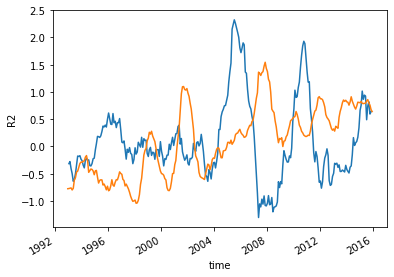

In [158]:
R1_anom_bot.plot(label='R1')
R2_anom_bot.plot(label='R2');

### __Bottom anomaly budget__

In [159]:
(- dVdt_anom_bot + psi_anom_bot + omega_anom_bot + R1_anom_bot + R2_anom_bot).mean('time')

<xarray.DataArray ()>
array(-0.00234837)

In [160]:
anom_budget = - dVdt_anom_bot + psi_anom_bot + omega_anom_bot + R1_anom_bot + R2_anom_bot
anom_budget

<xarray.DataArray (time: 288)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
       -6.95186004e-03, -6.89778678e-03, -6.52322762e-03, -6.44601258e-03,
       -6.47411003e-03, -6.40668600e-03, -6.44868864e-03, -6.32605313e-03,
       -5.73800991e-03, -5.08538109e-03, -4.39572494e-03, -3.67485826e-03,
       -3.31619142e-03, -2.98305731e-03, -3.14603378e-03, -3.52561753e-03,
       -3.85098630e-03, -3.97503600e-03, -3.82252358e-03, -3.64296682e-03,
       -3.40357562e-03, -2.97105150e-03, -2.47704962e-03, -2.20079845e-03,
       -2.07032200e-03, -1.98660969e-03, -1.60389358e-03, -1.34259836e-03,
       -1.41170769e-03, -1.41397438e-03, -1.57228123e-03, -1.62928953e-03,
       -2.08205611e-03, -2.69591983e-03, -3.13889511e-03, -3.27940931e-03,
       -2.87016125e-03, -2.24532650e-03, -1.71136431e-03, -1.26529701e-03,
       -6.97845674e-04, -4.07549096e-04,  6.58936225e-05,  1.54241823e-04,
        4.64774189e-04,  5.84656397e-04,  6.21268122e-04,  6.89479042e-04,
        5.68655593e-04,  4.42541110e-04,  3.20562396e-04,  4.98509184e-04,
        7.22499058e-04,  8.85119027e-04,  1.23783455e-03,  1.75035793e-03,
        2.41023700e-03,  2.93341022e-03,  3.21959149e-03,  2.92948672e-03,
        2.34125795e-03,  1.72024345e-03,  9.72305237e-04,  4.11662671e-04,
       -2.70061510e-04, -8.96563718e-04, -1.84474017e-03, -2.42366648e-03,
...
        4.55083317e-03,  5.06809278e-03,  5.42401099e-03,  5.58061740e-03,
        4.84984605e-03,  3.67579883e-03,  2.54264988e-03,  2.28805753e-03,
        2.68256414e-03,  3.41952230e-03,  4.52311686e-03,  5.55423022e-03,
        6.43254692e-03,  7.58447757e-03,  8.92674104e-03,  1.07616159e-02,
        1.30651435e-02,  1.56939293e-02,  1.82450446e-02,  2.00475564e-02,
        2.19951955e-02,  2.33851723e-02,  2.40129156e-02,  2.44269349e-02,
        2.47339438e-02,  2.40959256e-02,  2.29760830e-02,  2.13081173e-02,
        1.94768216e-02,  1.74709082e-02,  1.51802466e-02,  1.33538554e-02,
        1.08868758e-02,  8.73296636e-03,  7.23202839e-03,  6.20263059e-03,
        5.25944750e-03,  5.41602228e-03,  5.52061989e-03,  5.79531151e-03,
        6.41366813e-03,  6.46624335e-03,  6.85997441e-03,  6.73217332e-03,
        7.06072119e-03,  7.48821973e-03,  7.81750900e-03,  7.85102326e-03,
        8.03982430e-03,  7.62849867e-03,  7.54972982e-03,  7.07429180e-03,
        6.00292385e-03,  5.54869709e-03,  5.12093678e-03,  4.61355313e-03,
        4.24793382e-03,  3.91415199e-03,  3.50070401e-03,  3.43085553e-03,
        3.42692075e-03,  3.81256036e-03,  4.17361382e-03,  5.47435010e-03,
        6.82086344e-03,  7.82597923e-03,  9.11803237e-03,  1.03803872e-02,
        1.15886676e-02,  1.27886691e-02,  1.39655207e-02,  1.50147595e-02,
        1.58585405e-02,  1.66465782e-02,  1.74743842e-02,  1.73961845e-02,
        1.33332475e-02,  1.20511760e-02,  1.19918302e-02,             nan])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

In [161]:
anom_bdgt_nores = - dVdt_anom_bot + psi_anom_bot + omega_anom_bot
anom_bdgt_nores

<xarray.DataArray (time: 288)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,  1.08205529,  1.03869371,  1.16043841,
        1.28998469,  1.40221626,  1.21844593,  1.06166891,  0.80080698,
        0.62343709,  0.56223296,  0.47895258,  0.51784949,  0.54988466,
        0.61114976,  0.65537618,  0.44795364,  0.38445979,  0.51324744,
        0.71824252,  0.79326538,  0.76883935,  0.73376079,  0.67265961,
        0.73263124,  0.50585045,  0.39021598,  0.37863429,  0.49122478,
        0.45591974,  0.41637904,  0.33847941,  0.33307027,  0.3304491 ,
        0.34325969,  0.43701472,  0.22942408,  0.19809985,  0.27595833,
        0.31192711,  0.20714655,  0.10496515,  0.29461801,  0.19511414,
        0.26326172,  0.17771048,  0.1179591 , -0.04395569,  0.18904223,
        0.43351182,  0.53656165,  0.52442646,  0.77167383,  0.92466817,
        0.78827666,  0.88739119,  0.86467012,  1.04208566,  1.11864537,
        1.32723734,  1.24038952,  1.01056315,  1.18615033,  1.14019045,
        0.9116421 ,  0.85320852,  0.70748874,  0.41383702,  0.38462891,
        0.01354556, -0.04120295, -0.08326106,  0.01992924,  0.02477212,
       -0.20276852, -0.21421475, -0.11882585, -0.09123333, -0.03268151,
        0.14152944,  0.08954315,  0.2324795 ,  0.3287306 ,  0.53838355,
        0.3608369 ,  0.58527108,  0.68183261,  0.8831071 ,  0.81195125,
...
       -0.48064631, -0.36275228, -0.354611  , -0.35313904, -0.13709762,
        0.03718924,  0.23099836,  0.52733412,  0.4800031 ,  0.62821664,
        0.72486847,  0.8184966 ,  0.5798872 ,  0.61016661,  0.51376259,
        0.52911394,  0.35075501, -0.01406769,  0.06348173,  0.06334282,
        0.08299896, -0.00909228, -0.19512355, -0.26085669, -0.45577273,
       -0.96772164, -1.22912624, -1.57719322, -1.53692199, -1.4939586 ,
       -1.57948262, -1.56365118, -1.79064367, -1.94202567, -2.08025638,
       -2.1218157 , -2.05918022, -1.7844906 , -1.53100551, -1.3636461 ,
       -1.36472299, -0.95190045, -0.88190915, -0.73863823, -0.43558054,
       -0.34439372, -0.5526225 , -0.5568112 , -0.48368713, -0.24412503,
       -0.22895929, -0.1002837 , -0.20294495, -0.42709163, -0.50841372,
       -0.42618253, -0.48154407, -0.33474139,  0.16159354,  0.31803797,
        0.37362319,  0.26015202,  0.17884925,  0.03535711, -0.03838814,
       -0.03457316,  0.0586877 , -0.19123123, -0.17715187, -0.24706143,
       -0.36244888, -0.39787319, -0.35332882, -0.49580165, -0.39021652,
       -0.35164584, -0.26674675, -0.43020275, -0.55125461, -0.67316914,
       -0.93128535, -0.73419855, -0.74398523, -0.82570053, -0.97349997,
       -1.13875873, -1.45514888, -1.56682984, -1.79199865, -1.63672882,
       -1.71626066, -1.70185058, -1.30669562, -1.58276771, -1.60469093,
       -1.33884533, -1.30080166,         nan])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

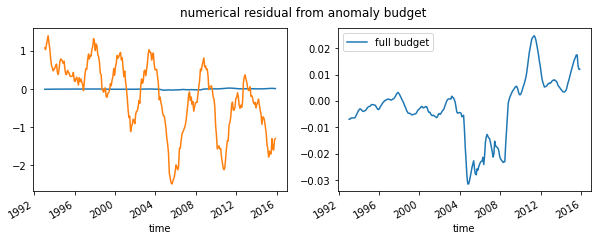

In [162]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
anom_budget.plot(ax=ax0, label='full budget')
anom_bdgt_nores.plot(ax=ax0, label='no residuals')

anom_budget.plot(ax=ax1, label='full budget')

plt.legend()
plt.suptitle('numerical residual from anomaly budget');

## BOTTOM Anomaly

In [80]:
import warnings
warnings.filterwarnings("ignore")

In [81]:
year_start_index = list(np.arange(0, 23, 5) * 12) #[0, 12, 24, 36, 48, ]

In [82]:
bot_wm = wmt_budget_terms.sel(sigma2_bin=slice(1037.115, 1037.5)) / 1e6
anom_unrolled = bot_wm.groupby('time.month') - clim(clim_ds)
anom = anom_unrolled.rolling(time=12).mean(dim='time')

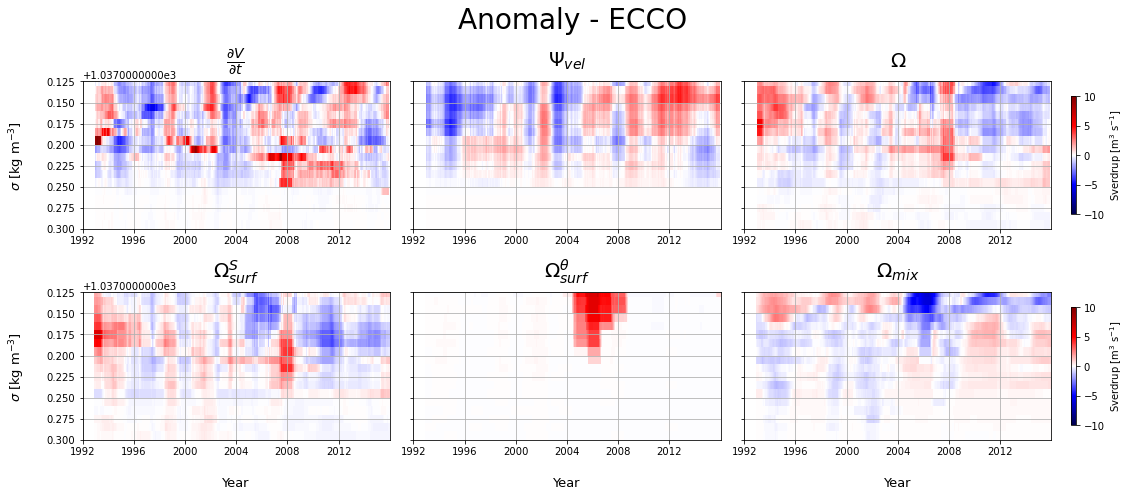

In [83]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

c = ax[0,0].pcolormesh(anom.dVdt.time.values, 
                   anom.dVdt.sigma2_bin, 
                   anom.dVdt.T, vmin=-10, vmax=10, cmap='seismic')
ax[0,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=13, labelpad=20)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20, pad=15)
#ax[0,0].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,0].set_xticklabels(np.arange(2006, 2011))
ax[0,0].grid()
ax[0,0].set_ylim(1037.3, 1037.125)

c_psi = ax[0,1].pcolormesh(anom.psi_vel.time.values, anom.psi_vel.sigma2_bin, anom.psi_vel.T,
                        vmin=-10, vmax=10, cmap='seismic')
ax[0,1].set_title(r'$\Psi_{vel}$', fontsize=20, pad=15)
#ax[0,1].set_ylim(1037.3, 1036.5)
#ax[0,1].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,1].set_xticklabels(np.arange(2006, 2011))
ax[0,1].grid()

c_omega = ax[0,2].pcolormesh(anom.omega_trans_rate.time.values, anom.omega_trans_rate.sigma2_bin, anom.omega_trans_rate.T,
                        vmin=-10, vmax=10, cmap='seismic')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[0,2])
ax[0,2].set_title(r'$\Omega$', fontsize=20, pad=15)
#ax[0,2].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,2].set_xticklabels(np.arange(2006, 2011))
ax[0,2].grid()

c_surf_slt = ax[1,0].pcolormesh(anom.omega_surf_slt.time.values, 
                                anom.omega_surf_slt.sigma2_bin, 
                                anom.omega_surf_slt.T, vmin=-10, vmax=10, cmap='seismic')
ax[1,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=13, labelpad=20)
ax[1,0].set_xlabel('Year', fontsize=13, labelpad=20)
ax[1,0].set_title('$\Omega^{S}_{surf}$', fontsize=20, pad=15)
#ax[1,0].set_xticks(anom.dVdt.time[year_start_index])
#ax[1,0].set_xticklabels(np.arange(2006, 2011))
ax[1,0].grid()

c_surf_th = ax[1,1].pcolormesh(anom.omega_surf_th.time.values, anom.omega_surf_th.sigma2_bin, 
                        anom.omega_surf_th.T, vmin=-10, vmax=10, cmap='seismic')
ax[1,1].set_xlabel('Year', fontsize=13, labelpad=20)
ax[1,1].set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20, pad=15)
#ax[1,1].set_ylim(1037.3, 1036.5)
#ax[1,1].set_xticks(anom.dVdt.time[year_start_index])
#ax[1,1].set_xticklabels(np.arange(2006, 2011))
ax[1,1].grid()

c_mix = ax[1,2].pcolormesh(anom.omega_mix.time.values, anom.omega_mix.sigma2_bin, anom.omega_mix.T, 
                        vmin=-10, vmax=10, cmap='seismic')
plt.colorbar(c_mix, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[1,2])
ax[1,2].set_xlabel('Year', fontsize=13, labelpad=20)
ax[1,2].set_title(r'$\Omega_{mix}$', fontsize=20, pad=15)
#ax[1,2].set_xticks(anom.dVdt.time[year_start_index])
#ax[1,2].set_xticklabels(np.arange(2006, 2011))
ax[1,2].grid()

plt.suptitle('Anomaly - ECCO', fontsize=28)
plt.tight_layout();

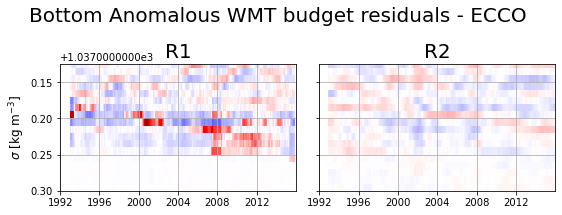

In [84]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

R1_anom = ax0.pcolormesh(anom.R1.time.values, 
                   anom.R1.sigma2_bin, 
                   anom.R1.T, vmin=-10, vmax=10, cmap='seismic')
ax0.set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax0.set_title('R1', fontsize=20)
#ax[0,0].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,0].set_xticklabels(np.arange(2006, 2011))
ax0.grid()
ax0.set_ylim(1037.3, 1037.125)

R2_anom = ax1.pcolormesh(anom.R2.time.values, anom.R2.sigma2_bin, anom.R2.T,
                        vmin=-10, vmax=10, cmap='seismic')
ax1.set_title('R2', fontsize=20)
#ax[0,1].set_ylim(1037.3, 1036.5)
#ax[0,1].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,1].set_xticklabels(np.arange(2006, 2011))
ax1.grid()

plt.suptitle('Bottom Anomalous WMT budget residuals - ECCO', fontsize=20)
plt.tight_layout();

In [85]:
anom

<xarray.Dataset>
Dimensions:               (sigma2_bin: 37, time: 288)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 1992-01-15 ... 2015-12-14
    time_snp              (time) datetime64[ns] NaT 1992-03-01 ... NaT
    month                 (time) int64 1 2 3 4 5 6 7 8 9 ... 5 6 7 8 9 10 11 12
Data variables: (12/17)
    R1                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R2                    (time, sigma2_bin) float64 nan nan ... 0.01865
    dVdt                  (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_mix             (time, sigma2_bin) float64 nan nan ... 0.002479
    omega_mix_slt         (time, sigma2_bin) float64 nan nan ... 0.001735
    omega_mix_th          (time, sigma2_bin) float64 nan nan ... 0.0007436
    ...                    ...
    omega_total_th        (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate      (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate_slt  (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate_th   (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_adv               (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_vel               (time, sigma2_bin) float64 nan nan nan ... nan nan nan

In [86]:
anom_bot = - anom.isel(sigma2_bin=-1) + anom.isel(sigma2_bin=0)
anom_bot

<xarray.Dataset>
Dimensions:               (time: 288)
Coordinates:
  * time                  (time) datetime64[ns] 1992-01-15 ... 2015-12-14
    time_snp              (time) datetime64[ns] NaT 1992-03-01 ... NaT
    month                 (time) int64 1 2 3 4 5 6 7 8 9 ... 5 6 7 8 9 10 11 12
Data variables: (12/17)
    R1                    (time) float64 nan nan nan nan ... 0.5945 0.6387 nan
    R2                    (time) float64 nan nan nan ... 0.7564 0.6741 0.6408
    dVdt                  (time) float64 nan nan nan nan ... 2.211 2.196 nan
    omega_mix             (time) float64 nan nan nan ... -2.517 -2.471 -2.488
    omega_mix_slt         (time) float64 nan nan nan nan ... 2.932 2.967 2.967
    omega_mix_th          (time) float64 nan nan nan ... -5.448 -5.438 -5.455
    ...                    ...
    omega_total_th        (time) float64 nan nan nan nan ... 1.61 1.436 nan
    omega_trans_rate      (time) float64 nan nan nan nan ... -0.6008 -0.5405 nan
    omega_trans_rate_slt  (time) float64 nan nan nan nan ... 4.028 4.078 nan
    omega_trans_rate_th   (time) float64 nan nan nan nan ... -4.629 -4.619 nan
    psi_adv               (time) float64 nan nan nan nan ... 2.228 2.108 nan
    psi_vel               (time) float64 nan nan nan nan ... 1.473 1.436 nan

### $\frac{\partial V}{\partial t}$

In [87]:
dVdt_anom_bot = anom_bot.dVdt

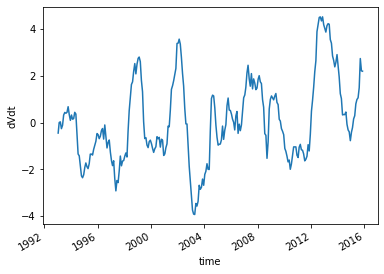

In [88]:
dVdt_anom_bot.plot();

### $\Psi$

In [89]:
psi_anom_bot = anom_bot.psi_vel

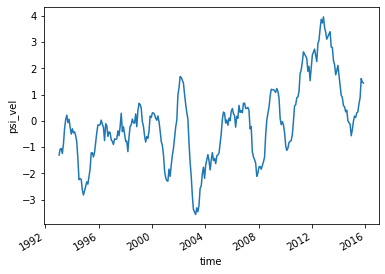

In [90]:
psi_anom_bot.plot();

### $\Omega$

In [91]:
omega_anom_bot = anom_bot.omega_trans_rate

In [92]:
omegas

['omega_mix',
 'omega_mix_slt',
 'omega_mix_th',
 'omega_surf',
 'omega_surf_slt',
 'omega_surf_th',
 'omega_trans_rate',
 'omega_trans_rate_slt',
 'omega_trans_rate_th']

In [93]:
omega_surf_slt_anom_bot = anom_bot.omega_surf_slt
omega_surf_th_anom_bot = anom_bot.omega_surf_th
omega_mix_anom_bot = anom_bot.omega_mix

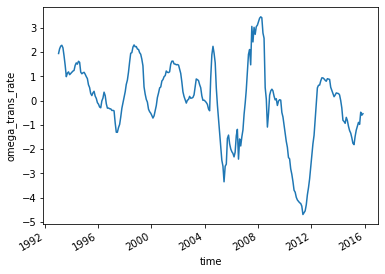

In [94]:
omega_anom_bot.plot();

### Residuals

In [95]:
R1_anom_bot = anom_bot.R1

In [96]:
R2_anom_bot = anom_bot.R2

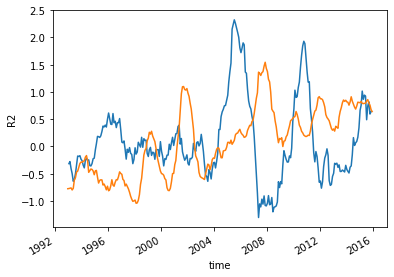

In [97]:
R1_anom_bot.plot(label='R1')
R2_anom_bot.plot(label='R2');

In [98]:
dVdt_anom_bot.time[-1]

<xarray.DataArray 'time' ()>
array('2015-12-14T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time      datetime64[ns] 2015-12-14
    time_snp  datetime64[ns] NaT
    month     int64 12

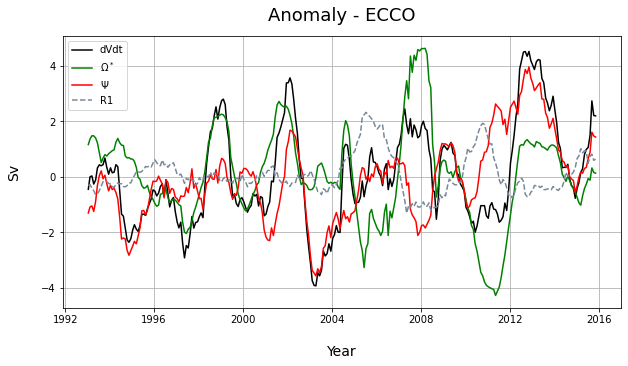

In [99]:
fig = plt.subplots(figsize=(10,5))
plt.plot(dVdt_anom_bot.time, dVdt_anom_bot, label='dVdt', color='k')
plt.plot(omega_anom_bot.time, (omega_anom_bot+R2_anom_bot), label=r'$\Omega^*$', color='green')
plt.plot(psi_anom_bot.time, psi_anom_bot, label=r'$\Psi$', color='red')
plt.plot(R1_anom_bot.time, R1_anom_bot, label='R1', color='lightslategray', linestyle='--')
#plt.plot(R2_anom_bot.time, R2_anom_bot, label='R2', color='salmon', linestyle='--')
plt.title('Anomaly - ECCO', fontsize=18, pad=15)
plt.ylabel('Sv', fontsize=14, labelpad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
#plt.xlim(dVdt_anom_bot.time[12], dVdt_anom_bot.time[-1]) #1993-2015

plt.legend()
plt.grid();

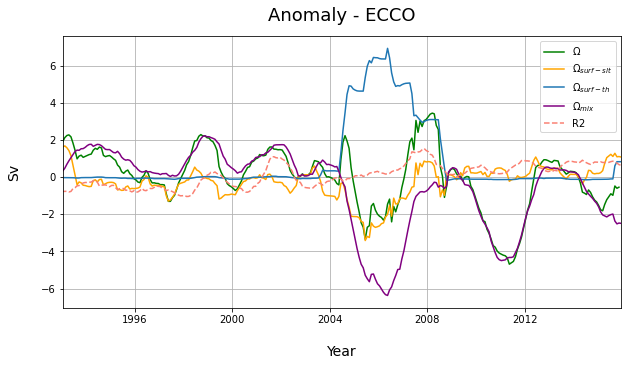

In [100]:
fig = plt.subplots(figsize=(10,5))
plt.plot(omega_anom_bot.time, omega_anom_bot, label=r'$\Omega$', color='green')
plt.plot(omega_surf_slt_anom_bot.time, omega_surf_slt_anom_bot, 
         label=r'$\Omega_{surf-slt}$', color='orange')
plt.plot(omega_surf_th_anom_bot.time, omega_surf_th_anom_bot, 
         label=r'$\Omega_{surf-th}$', color='C0')
plt.plot(omega_mix_anom_bot.time, omega_mix_anom_bot, 
         label=r'$\Omega_{mix}$', color='purple')
plt.plot(R2_anom_bot.time, R2_anom_bot, label='R2', color='salmon', linestyle='--')
plt.title('Anomaly - ECCO', fontsize=18, pad=15)
plt.ylabel('Sv', fontsize=14, labelpad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
plt.xlim(dVdt_anom_bot.time[12], dVdt_anom_bot.time[-1]) #1993-2015

plt.legend()
plt.grid();

### __Bottom anomaly budget__

In [101]:
(- dVdt_anom_bot + psi_anom_bot + omega_anom_bot + R1_anom_bot + R2_anom_bot).mean('time')

<xarray.DataArray ()>
array(-0.00234837)

In [102]:
anom_budget = - dVdt_anom_bot + psi_anom_bot + omega_anom_bot + R1_anom_bot + R2_anom_bot
anom_budget

<xarray.DataArray (time: 288)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
       -6.95186004e-03, -6.89778678e-03, -6.52322762e-03, -6.44601258e-03,
       -6.47411003e-03, -6.40668600e-03, -6.44868864e-03, -6.32605313e-03,
       -5.73800991e-03, -5.08538109e-03, -4.39572494e-03, -3.67485826e-03,
       -3.31619142e-03, -2.98305731e-03, -3.14603378e-03, -3.52561753e-03,
       -3.85098630e-03, -3.97503600e-03, -3.82252358e-03, -3.64296682e-03,
       -3.40357562e-03, -2.97105150e-03, -2.47704962e-03, -2.20079845e-03,
       -2.07032200e-03, -1.98660969e-03, -1.60389358e-03, -1.34259836e-03,
       -1.41170769e-03, -1.41397438e-03, -1.57228123e-03, -1.62928953e-03,
       -2.08205611e-03, -2.69591983e-03, -3.13889511e-03, -3.27940931e-03,
       -2.87016125e-03, -2.24532650e-03, -1.71136431e-03, -1.26529701e-03,
       -6.97845674e-04, -4.07549096e-04,  6.58936225e-05,  1.54241823e-04,
        4.64774189e-04,  5.84656397e-04,  6.21268122e-04,  6.89479042e-04,
        5.68655593e-04,  4.42541110e-04,  3.20562396e-04,  4.98509184e-04,
        7.22499058e-04,  8.85119027e-04,  1.23783455e-03,  1.75035793e-03,
        2.41023700e-03,  2.93341022e-03,  3.21959149e-03,  2.92948672e-03,
        2.34125795e-03,  1.72024345e-03,  9.72305237e-04,  4.11662671e-04,
       -2.70061510e-04, -8.96563718e-04, -1.84474017e-03, -2.42366648e-03,
...
        4.55083317e-03,  5.06809278e-03,  5.42401099e-03,  5.58061740e-03,
        4.84984605e-03,  3.67579883e-03,  2.54264988e-03,  2.28805753e-03,
        2.68256414e-03,  3.41952230e-03,  4.52311686e-03,  5.55423022e-03,
        6.43254692e-03,  7.58447757e-03,  8.92674104e-03,  1.07616159e-02,
        1.30651435e-02,  1.56939293e-02,  1.82450446e-02,  2.00475564e-02,
        2.19951955e-02,  2.33851723e-02,  2.40129156e-02,  2.44269349e-02,
        2.47339438e-02,  2.40959256e-02,  2.29760830e-02,  2.13081173e-02,
        1.94768216e-02,  1.74709082e-02,  1.51802466e-02,  1.33538554e-02,
        1.08868758e-02,  8.73296636e-03,  7.23202839e-03,  6.20263059e-03,
        5.25944750e-03,  5.41602228e-03,  5.52061989e-03,  5.79531151e-03,
        6.41366813e-03,  6.46624335e-03,  6.85997441e-03,  6.73217332e-03,
        7.06072119e-03,  7.48821973e-03,  7.81750900e-03,  7.85102326e-03,
        8.03982430e-03,  7.62849867e-03,  7.54972982e-03,  7.07429180e-03,
        6.00292385e-03,  5.54869709e-03,  5.12093678e-03,  4.61355313e-03,
        4.24793382e-03,  3.91415199e-03,  3.50070401e-03,  3.43085553e-03,
        3.42692075e-03,  3.81256036e-03,  4.17361382e-03,  5.47435010e-03,
        6.82086344e-03,  7.82597923e-03,  9.11803237e-03,  1.03803872e-02,
        1.15886676e-02,  1.27886691e-02,  1.39655207e-02,  1.50147595e-02,
        1.58585405e-02,  1.66465782e-02,  1.74743842e-02,  1.73961845e-02,
        1.33332475e-02,  1.20511760e-02,  1.19918302e-02,             nan])
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    time_snp  (time) datetime64[ns] NaT 1992-03-01 1992-04-01 ... 2015-12-01 NaT
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [103]:
anom_bdgt_nores = - dVdt_anom_bot + psi_anom_bot + omega_anom_bot
anom_bdgt_nores

<xarray.DataArray (time: 288)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,  1.08205529,  1.03869371,  1.16043841,
        1.28998469,  1.40221626,  1.21844593,  1.06166891,  0.80080698,
        0.62343709,  0.56223296,  0.47895258,  0.51784949,  0.54988466,
        0.61114976,  0.65537618,  0.44795364,  0.38445979,  0.51324744,
        0.71824252,  0.79326538,  0.76883935,  0.73376079,  0.67265961,
        0.73263124,  0.50585045,  0.39021598,  0.37863429,  0.49122478,
        0.45591974,  0.41637904,  0.33847941,  0.33307027,  0.3304491 ,
        0.34325969,  0.43701472,  0.22942408,  0.19809985,  0.27595833,
        0.31192711,  0.20714655,  0.10496515,  0.29461801,  0.19511414,
        0.26326172,  0.17771048,  0.1179591 , -0.04395569,  0.18904223,
        0.43351182,  0.53656165,  0.52442646,  0.77167383,  0.92466817,
        0.78827666,  0.88739119,  0.86467012,  1.04208566,  1.11864537,
        1.32723734,  1.24038952,  1.01056315,  1.18615033,  1.14019045,
        0.9116421 ,  0.85320852,  0.70748874,  0.41383702,  0.38462891,
        0.01354556, -0.04120295, -0.08326106,  0.01992924,  0.02477212,
       -0.20276852, -0.21421475, -0.11882585, -0.09123333, -0.03268151,
        0.14152944,  0.08954315,  0.2324795 ,  0.3287306 ,  0.53838355,
        0.3608369 ,  0.58527108,  0.68183261,  0.8831071 ,  0.81195125,
...
       -0.48064631, -0.36275228, -0.354611  , -0.35313904, -0.13709762,
        0.03718924,  0.23099836,  0.52733412,  0.4800031 ,  0.62821664,
        0.72486847,  0.8184966 ,  0.5798872 ,  0.61016661,  0.51376259,
        0.52911394,  0.35075501, -0.01406769,  0.06348173,  0.06334282,
        0.08299896, -0.00909228, -0.19512355, -0.26085669, -0.45577273,
       -0.96772164, -1.22912624, -1.57719322, -1.53692199, -1.4939586 ,
       -1.57948262, -1.56365118, -1.79064367, -1.94202567, -2.08025638,
       -2.1218157 , -2.05918022, -1.7844906 , -1.53100551, -1.3636461 ,
       -1.36472299, -0.95190045, -0.88190915, -0.73863823, -0.43558054,
       -0.34439372, -0.5526225 , -0.5568112 , -0.48368713, -0.24412503,
       -0.22895929, -0.1002837 , -0.20294495, -0.42709163, -0.50841372,
       -0.42618253, -0.48154407, -0.33474139,  0.16159354,  0.31803797,
        0.37362319,  0.26015202,  0.17884925,  0.03535711, -0.03838814,
       -0.03457316,  0.0586877 , -0.19123123, -0.17715187, -0.24706143,
       -0.36244888, -0.39787319, -0.35332882, -0.49580165, -0.39021652,
       -0.35164584, -0.26674675, -0.43020275, -0.55125461, -0.67316914,
       -0.93128535, -0.73419855, -0.74398523, -0.82570053, -0.97349997,
       -1.13875873, -1.45514888, -1.56682984, -1.79199865, -1.63672882,
       -1.71626066, -1.70185058, -1.30669562, -1.58276771, -1.60469093,
       -1.33884533, -1.30080166,         nan])
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    time_snp  (time) datetime64[ns] NaT 1992-03-01 1992-04-01 ... 2015-12-01 NaT
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

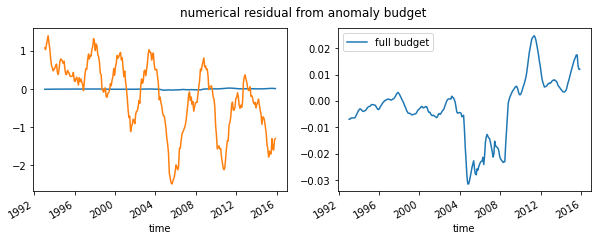

In [104]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
anom_budget.plot(ax=ax0, label='full budget')
anom_bdgt_nores.plot(ax=ax0, label='no residuals')

anom_budget.plot(ax=ax1, label='full budget')

plt.legend()
plt.suptitle('numerical residual from anomaly budget');

### Boundary $\Omega$s

## Indices

In [105]:
indices

<xarray.Dataset>
Dimensions:          (time: 288)
Coordinates:
  * time             (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Data variables:
    ecco             (time) float32 -1.17 -0.4881 0.557 ... 0.9576 0.7435 -2.925
    enso             (time) float32 1.884 1.786 1.615 ... 2.599 2.746 2.795
    fw_flx           (time) float32 -1.3 -0.8691 -2.231 ... 0.3026 0.3995 1.555
    heat_flx         (time) float32 0.001594 -0.8675 -1.919 ... -0.1446 5.151
    sam              (time) float64 -0.1225 -0.8858 -0.616 ... 0.8338 0.3187
    windstress_curl  (time) float64 -0.2194 1.103 -0.4354 ... -0.5297 0.2877

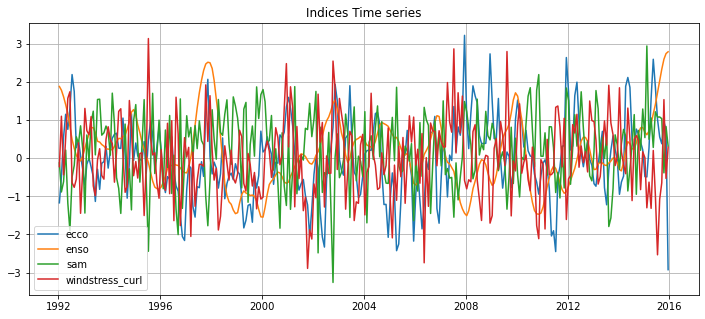

In [106]:
fig, ax = plt.subplots(figsize=(12,5))
for i in indices.variables:
    if i =='time':
        continue
    if i=='fw_flx':
        continue
    if i=='heat_flx':
        continue
    ax.plot(indices.time, indices[i], label=f'{indices[i].name}')
    
plt.legend()
plt.grid()
plt.title('Indices Time series');

## Heat map of Corralation matrices

In [107]:
import seaborn as sn

In [108]:
indices_df = indices.to_dataframe()
indices_df.head()

,ecco,enso,fw_flx,heat_flx,sam,windstress_curl
time,,,,,,
1992-01-15,-1.170194,1.883747,-1.300427,0.001594,-0.122525,-0.219413
1992-02-13,-0.488146,1.786449,-0.869125,-0.867469,-0.885817,1.102549
1992-03-15,0.556974,1.614739,-2.230632,-1.918516,-0.616002,-0.435378
1992-04-14,1.153485,1.408937,-0.181473,0.300216,0.213964,0.524290
1992-05-15,0.758463,1.166296,-0.546701,0.713055,-1.179878,1.575049


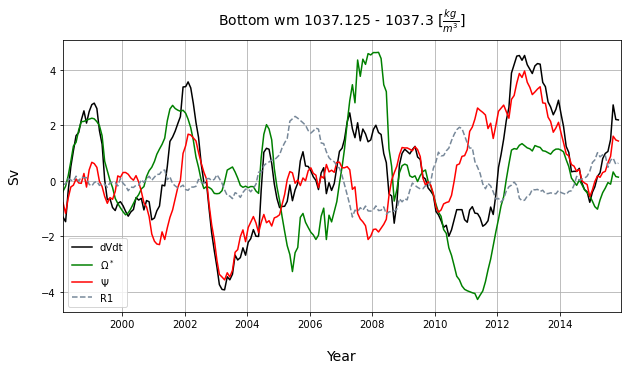

In [109]:
fig = plt.subplots(figsize=(10,5))
plt.plot(dVdt_anom_bot.time, dVdt_anom_bot, label='dVdt', color='k')
plt.plot(omega_anom_bot.time, (omega_anom_bot+R2_anom_bot), label=r'$\Omega^*$', color='green')
plt.plot(psi_anom_bot.time, psi_anom_bot, label=r'$\Psi$', color='red')
plt.plot(R1_anom_bot.time, R1_anom_bot, label='R1', color='lightslategray', linestyle='--')
#plt.plot(R2_anom_bot.time, R2_anom_bot, label='R2', color='salmon', linestyle='--')
plt.title(r'Bottom wm 1037.125 - 1037.3 [$\frac{kg}{m^3}$]', fontsize=14, pad=15)
plt.ylabel('Sv', fontsize=14, labelpad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
plt.xlim(dVdt_anom_bot.time[73], dVdt_anom_bot.time[-1]) #2007-2010

plt.legend()
plt.grid();

In [110]:
omega_star = omega_anom_bot + R2_anom_bot

In [111]:
ds = xr.merge([dVdt_anom_bot.rename('dvdt'), psi_anom_bot.rename('psi'), omega_star.rename('omega*')]).drop(['month', 'time_snp'])
ds

<xarray.Dataset>
Dimensions:  (time: 288)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Data variables:
    dvdt     (time) float64 nan nan nan nan nan ... 1.49 2.738 2.211 2.196 nan
    psi      (time) float64 nan nan nan nan nan ... 0.886 1.611 1.473 1.436 nan
    omega*   (time) float64 nan nan nan nan nan ... 0.321 0.1556 0.1337 nan

In [122]:
ds_omega = xr.merge([omega_anom_bot.rename('omega'), omega_mix_anom_bot.rename('mix'),
                     omega_surf_slt_anom_bot.rename('surf_slt'), omega_surf_th_anom_bot.rename('surf_th')]).drop(['month', 'time_snp'])

In [124]:
omega_df = ds_omega.to_dataframe()

In [112]:
ds.coords

Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

In [113]:
indices.coords

Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

In [114]:
budget_df = ds.to_dataframe()

In [115]:
budget_df.tail()

,dvdt,psi,omega*
time,,,
2015-08-15,1.490057,0.885958,-0.119296
2015-09-14,2.737592,1.610785,0.321022
2015-10-15,2.211281,1.473193,0.155614
2015-11-14,2.196468,1.436117,0.133656
2015-12-14,NaN,NaN,NaN


### Correlation matrix of all terms (budget & indices)

In [116]:
budget_ind = pd.concat([budget_df, indices_df], axis=1)
budget_ind.tail()

,dvdt,psi,omega*,ecco,enso,fw_flx,heat_flx,sam,windstress_curl
time,,,,,,,,,
2015-08-15,1.490057,0.885958,-0.119296,0.559372,2.045500,0.225318,-0.579957,1.083196,-1.076998
2015-09-14,2.737592,1.610785,0.321022,0.380170,2.336527,-0.677235,-0.413434,1.039752,-0.643988
2015-10-15,2.211281,1.473193,0.155614,0.957576,2.599419,0.302553,-0.738937,-0.384399,1.538923
2015-11-14,2.196468,1.436117,0.133656,0.743491,2.746488,0.399466,-0.144605,0.833789,-0.529735
2015-12-14,NaN,NaN,NaN,-2.925005,2.794896,1.555206,5.150780,0.318706,0.287670


In [125]:
omega_ind = pd.concat([omega_df, indices_df], axis=1)
omega_ind.head()

,omega,mix,surf_slt,surf_th,ecco,enso,fw_flx,heat_flx,sam,windstress_curl
time,,,,,,,,,,
1992-01-15,NaN,NaN,NaN,NaN,-1.170194,1.883747,-1.300427,0.001594,-0.122525,-0.219413
1992-02-13,NaN,NaN,NaN,NaN,-0.488146,1.786449,-0.869125,-0.867469,-0.885817,1.102549
1992-03-15,NaN,NaN,NaN,NaN,0.556974,1.614739,-2.230632,-1.918516,-0.616002,-0.435378
1992-04-14,NaN,NaN,NaN,NaN,1.153485,1.408937,-0.181473,0.300216,0.213964,0.524290
1992-05-15,NaN,NaN,NaN,NaN,0.758463,1.166296,-0.546701,0.713055,-1.179878,1.575049


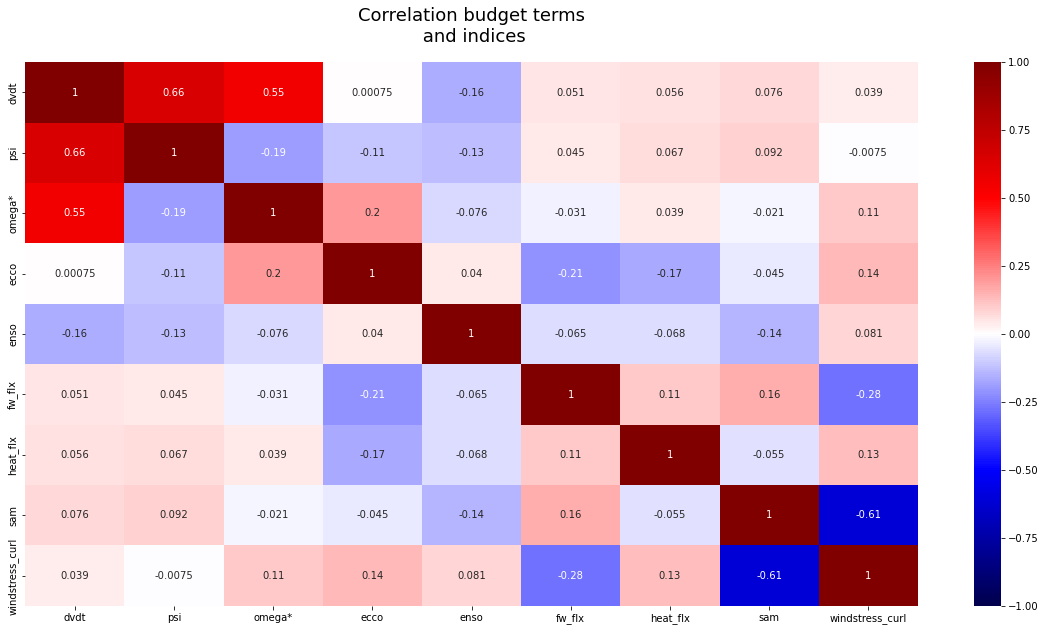

In [117]:
plt.figure(figsize=(20,10))
sn.heatmap(budget_ind.corr(), annot=True, cmap='seismic', vmin=-1, vmax=1)
plt.title('Correlation budget terms\n and indices', fontsize=18, pad=20.5);

In [118]:
corr = budget_ind.corr()
corr

,dvdt,psi,omega*,ecco,enso,fw_flx,heat_flx,sam,windstress_curl
dvdt,1.000000,0.655327,0.551419,0.000755,-0.157868,0.051062,0.055594,0.075594,0.038536
psi,0.655327,1.000000,-0.190677,-0.113987,-0.125978,0.045498,0.066887,0.091525,-0.007549
omega*,0.551419,-0.190677,1.000000,0.200544,-0.075979,-0.030702,0.039172,-0.021122,0.108266
ecco,0.000755,-0.113987,0.200544,1.000000,0.040300,-0.211307,-0.165878,-0.045092,0.140075
enso,-0.157868,-0.125978,-0.075979,0.040300,1.000000,-0.064801,-0.068467,-0.142116,0.081242
fw_flx,0.051062,0.045498,-0.030702,-0.211307,-0.064801,1.000000,0.105556,0.159329,-0.277577
heat_flx,0.055594,0.066887,0.039172,-0.165878,-0.068467,0.105556,1.000000,-0.054843,0.126801
sam,0.075594,0.091525,-0.021122,-0.045092,-0.142116,0.159329,-0.054843,1.000000,-0.613416
windstress_curl,0.038536,-0.007549,0.108266,0.140075,0.081242,-0.277577,0.126801,-0.613416,1.000000


In [127]:
omega_ind['psi'] = budget_df['psi']

In [130]:
omega_ind

,omega,mix,surf_slt,surf_th,ecco,enso,fw_flx,heat_flx,sam,windstress_curl,psi
time,,,,,,,,,,,
1992-01-15,NaN,NaN,NaN,NaN,-1.170194,1.883747,-1.300427,0.001594,-0.122525,-0.219413,NaN
1992-02-13,NaN,NaN,NaN,NaN,-0.488146,1.786449,-0.869125,-0.867469,-0.885817,1.102549,NaN
1992-03-15,NaN,NaN,NaN,NaN,0.556974,1.614739,-2.230632,-1.918516,-0.616002,-0.435378,NaN
1992-04-14,NaN,NaN,NaN,NaN,1.153485,1.408937,-0.181473,0.300216,0.213964,0.524290,NaN
1992-05-15,NaN,NaN,NaN,NaN,0.758463,1.166296,-0.546701,0.713055,-1.179878,1.575049,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2015-08-15,-0.978669,-1.987915,1.115247,-0.095807,0.559372,2.045500,0.225318,-0.579957,1.083196,-1.076998,0.885958
2015-09-14,-0.477883,-2.365135,1.284428,0.613017,0.380170,2.336527,-0.677235,-0.413434,1.039752,-0.643988,1.610785
2015-10-15,-0.600757,-2.516545,1.095096,0.830886,0.957576,2.599419,0.302553,-0.738937,-0.384399,1.538923,1.473193


In [131]:
omega_ind.corr()

,omega,mix,surf_slt,surf_th,ecco,enso,fw_flx,heat_flx,sam,windstress_curl,psi
omega,1.000000,0.724356,0.290775,-0.076466,0.155167,-0.015197,-0.048709,0.053337,-0.033842,0.108393,-0.343390
mix,0.724356,1.000000,0.383520,-0.677290,0.084316,-0.017904,-0.006309,0.079734,-0.002474,0.028221,-0.242369
surf_slt,0.290775,0.383520,1.000000,-0.642646,0.340844,0.032439,-0.039978,0.141912,0.069552,0.088888,0.123162
surf_th,-0.076466,-0.677290,-0.642646,1.000000,-0.117775,-0.011452,-0.010577,-0.116963,-0.059363,0.020543,-0.083329
ecco,0.155167,0.084316,0.340844,-0.117775,1.000000,0.040300,-0.211307,-0.165878,-0.045092,0.140075,-0.113987
enso,-0.015197,-0.017904,0.032439,-0.011452,0.040300,1.000000,-0.064801,-0.068467,-0.142116,0.081242,-0.125978
fw_flx,-0.048709,-0.006309,-0.039978,-0.010577,-0.211307,-0.064801,1.000000,0.105556,0.159329,-0.277577,0.045498
heat_flx,0.053337,0.079734,0.141912,-0.116963,-0.165878,-0.068467,0.105556,1.000000,-0.054843,0.126801,0.066887
sam,-0.033842,-0.002474,0.069552,-0.059363,-0.045092,-0.142116,0.159329,-0.054843,1.000000,-0.613416,0.091525
windstress_curl,0.108393,0.028221,0.088888,0.020543,0.140075,0.081242,-0.277577,0.126801,-0.613416,1.000000,-0.007549


In [132]:
corr_omega = omega_ind.corr()
corr_omega

,omega,mix,surf_slt,surf_th,ecco,enso,fw_flx,heat_flx,sam,windstress_curl,psi
omega,1.000000,0.724356,0.290775,-0.076466,0.155167,-0.015197,-0.048709,0.053337,-0.033842,0.108393,-0.343390
mix,0.724356,1.000000,0.383520,-0.677290,0.084316,-0.017904,-0.006309,0.079734,-0.002474,0.028221,-0.242369
surf_slt,0.290775,0.383520,1.000000,-0.642646,0.340844,0.032439,-0.039978,0.141912,0.069552,0.088888,0.123162
surf_th,-0.076466,-0.677290,-0.642646,1.000000,-0.117775,-0.011452,-0.010577,-0.116963,-0.059363,0.020543,-0.083329
ecco,0.155167,0.084316,0.340844,-0.117775,1.000000,0.040300,-0.211307,-0.165878,-0.045092,0.140075,-0.113987
enso,-0.015197,-0.017904,0.032439,-0.011452,0.040300,1.000000,-0.064801,-0.068467,-0.142116,0.081242,-0.125978
fw_flx,-0.048709,-0.006309,-0.039978,-0.010577,-0.211307,-0.064801,1.000000,0.105556,0.159329,-0.277577,0.045498
heat_flx,0.053337,0.079734,0.141912,-0.116963,-0.165878,-0.068467,0.105556,1.000000,-0.054843,0.126801,0.066887
sam,-0.033842,-0.002474,0.069552,-0.059363,-0.045092,-0.142116,0.159329,-0.054843,1.000000,-0.613416,0.091525
windstress_curl,0.108393,0.028221,0.088888,0.020543,0.140075,0.081242,-0.277577,0.126801,-0.613416,1.000000,-0.007549


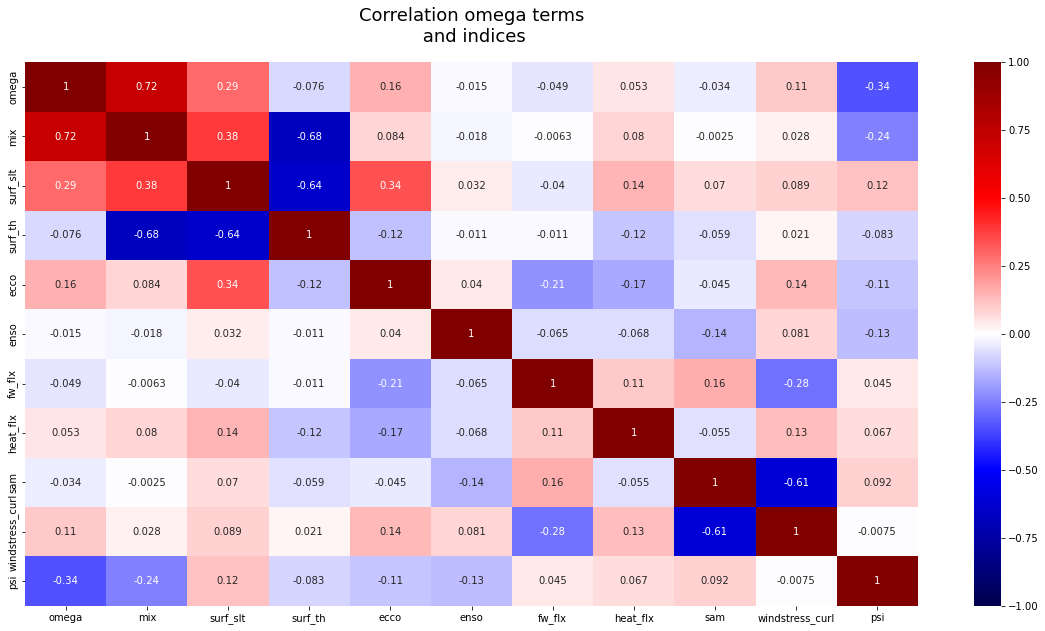

In [134]:
plt.figure(figsize=(20,10))
sn.heatmap(corr_omega, annot=True, cmap='seismic', vmin=-1, vmax=1)
plt.title('Correlation omega terms\n and indices', fontsize=18, pad=20.5);

In [119]:
dvdt_psi = corr.iloc[0, 1]
dvdt_omega = corr.iloc[0, 2]
psi_omega = corr.iloc[2, 1]

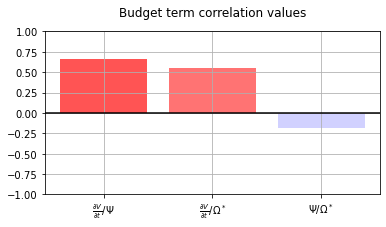

In [120]:
fig, ax0 = plt.subplots(1,1, figsize=(6,3))

ax0.bar(x=r'$\frac{\partial V}{\partial t}/\Psi$', height = dvdt_psi, color='red', alpha=0.67)
ax0.bar(x=r'$\frac{\partial V}{\partial t}/\Omega^*$', height = dvdt_omega, color='red', alpha=0.55)
ax0.bar(x=r'$\Psi/\Omega^*$', height= psi_omega, color='Blue', alpha=0.18)
ax0.axhline(y=0, color='k')
ax0.set_title(r'Budget term correlation values', fontsize=12, pad=15)
ax0.set_ylabel('')
ax0.grid()
ax0.set_ylim(-1,1);

In [169]:
# save df for corr-bars fig in stacked-figs dir
omega_ind.to_csv('ecco_omega_ind')